# LTCS 180 Final Project: A Distant and Close Reading of *Gone Girl*

### Tracy Truong and Deniz Ibrahimzade

For our project, we will be analyzing Gillian Flynn's 2012 mystery/thriller novel, *Gone Girl*, through lenses of close and distant reading.

Due to the structure of Gillian Flynn's novel, character models can be used to graph relationship shifts from the first part of the novel, Boy Loses Girl, to Boy Meets Girl, to Boy Gets Girl Back (Or Vice Versa). We decided to analyze this novel due to its two narrators, adding to the sentiment analysis from first-person perspectives with different views. Additionally, the mystery/thriller genre in which *Gone Girl* is written creates twists in the relationship between characters as information is revealed to both the reader and the characters— forming an interesting potential for the character networks. As the novel does not follow the traditional protagonist-antagonist model, the sentiment score will give an insight to the characters' turmoils and who the 'villain' is in their tale. 

For distant reading, we will look toward character networks generated based on spaCy's name entity recognition model for computing character interactions and sentiment analysis using the AFINN model. After we generate these networks, we will attempt to draw overarching conclusions based on BookNLP's natural language processing tools.

For close reading, we will analyze connections from the text based on the results of the character networks and determine if plot elements can be detected.

In [1]:
# project imports
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import json
from collections import Counter
from afinn import Afinn
import os
import sys
from termcolor import colored, cprint
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# load spacy english language model
ner = spacy.load("en_core_web_sm")

This project leverages the spaCy name entity recognition aspect of the existing project detailed in [Thu Vu data analytics](https://www.youtube.com/watch?v=fAHkJ_Dhr50)' video tutorial on creating a simple character network for *The Witcher*.

**In order to develop character networks that can help us understand *Gone Girl* better, we will be processing the three parts of the novel - Boy Loses Girl, Boy Meets Girl, Boy Gets Girl Back - separately.**

**For each part, we will generate 3 character networks to get a better sense of how character interactions and sentiments evolve:**
- Character Network (I): Character interactions and sentiments for the first half of the Part
- Character Network (II): Character interactions and sentiments for the first half of the Part
- Character Network (I, II combined): Character interactions and sentiments for the entire Part

Please see the Table of Contents below for navigation (note: links only work with notebook viewer).

## Table of Contents
* [Boy Loses Girl](#Boy_Loses_Girl)
    * [Character Network (I)](#cn_p1_i)
    * [Character Network (II)](#cn_p1_ii)
    * [Character Network (I, II combined)](#cn_p1_i_ii)
* [Boy Meets Girl](#Boy_Meets_Girl)
    * [Character Network (I)](#cn_p2_i)
    * [Character Network (II)](#cn_p2_ii)
    * [Character Network (I, II combined)](#cn_p2_i_ii)
* [Boy Gets Girl Back](#Boy_Gets_Girl_Back)
    * [Character Network (I)](#cn_p3_i)
    * [Character Network (II)](#cn_p3_ii)
    * [Character Network (I, II combined)](#cn_p3_i_ii)
* [Novel Analysis](#Novel_Analysis)
* [Project Conclusion](#Project_Conclusion)

## Boy Loses Girl <a class="anchor" id="Boy_Loses_Girl"></a>

### Extracting Character Entities Using Name Entity Recognition

To begin the process of breaking down the novel in order to generate useful data for character analysis, we will first run the text through spaCy's Name Entity Recognition model.

In [2]:
# load the first part of the book and run name entity recognition on it
gg1_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part1.txt")
gg1_text = open(gg1_book, encoding="utf8").read()
gg1_doc = ner(gg1_text)

In [3]:
# preview of the ner results
displacy.render(gg1_doc[0:766], style="ent", jupyter=True)

Because we are primarily interested in the character entities for our eventual construction of character networks, we want to run through the text to extract co-occurance data. This will require us to filter out character entities on a sentence-level granularity.

Before we do this, however, we will extract a character list using BookNLP's model for extracting character data. This will help us in the filtering process described above.

In [4]:
# functions for extracting novel information
# note: leveraged from the BookNLP documentation
def proc(filename):
    with open(filename) as file:
        data=json.load(file)
    return data

def get_counter_from_dependency_list(dep_list):
    counter=Counter()
    for token in dep_list:
        term=token["w"]
        tokenGlobalIndex=token["i"]
        counter[term]+=1
    return counter

# function for extracting character information
# note: leveraged from the BookNLP documentation
def create_character_data(data, printTop):
    character_data = {}
    for character in data["characters"]:

        agentList=character["agent"]
        patientList=character["patient"]
        possList=character["poss"]
        modList=character["mod"]

        character_id=character["id"]
        count=character["count"]

        referential_gender_distribution=referential_gender_prediction="unknown"

        if character["g"] is not None and character["g"] != "unknown":
            referential_gender_distribution=character["g"]["inference"]
            referential_gender=character["g"]["argmax"]

        mentions=character["mentions"]
        proper_mentions=mentions["proper"]
        max_proper_mention=""

        # create some empty lists we can append to
        poss_items = []
        agent_items = []
        patient_items = []
        mod_items = []
        
        # just print out information about named characters
        if len(mentions["proper"]) > 0:
            max_proper_mention=mentions["proper"][0]["n"]
            for k, v in get_counter_from_dependency_list(possList).most_common(printTop):
                poss_items.append((v,k))
            for k, v in get_counter_from_dependency_list(agentList).most_common(printTop):
                agent_items.append((v,k))
            for k, v in get_counter_from_dependency_list(patientList).most_common(printTop):
                patient_items.append((v,k))
            for k, v in get_counter_from_dependency_list(modList).most_common(printTop):
                mod_items.append((v,k))
        
            # print(character_id, count, max_proper_mention, referential_gender)
            character_data[character_id] = {"name": max_proper_mention,
                                            "id": character_id,
                                            "timesMentioned": count,
                                            "gender": referential_gender,
                                            "possList": poss_items,
                                            "agentList": agent_items,
                                            "patientList": patient_items,
                                            "modList": mod_items}
    
    return character_data

In [5]:
# utilize above functions to produce a list of characters in Gone Girl
gone_girl_data = proc(r"C:\Users\tracypaige\LTCS180\bookNLP_gillian_flynn\gone_girl\gone_girl.book")
gone_girl_character_data = create_character_data(gone_girl_data, 50)
gone_girl_characters_df = pd.DataFrame(gone_girl_character_data).T.reset_index(drop=True)[['name']]
# lowercase the names for uniformity for future processing
gone_girl_characters_df['name'] = gone_girl_characters_df['name'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [6]:
# remove rows with duplicates
gone_girl_characters_df = gone_girl_characters_df.drop_duplicates()
# take a look at the character list
pd.set_option('display.max_rows', None)
gone_girl_characters_df

,name
0,amy
1,nick
2,go
3,desi
4,boney
5,andie
6,tanner
7,rand
8,gilpin
9,greta


Although most of the characters seem to have processed correctly, we will manually go through them to ensure that the list is accurate. This is important because we want our character network to be as precise as possible, as the accuracy of the character nodes is contingent on the accuracy of the character list.

In [7]:
# manually remove inaccurate entries
gone_girl_characters_df = gone_girl_characters_df.drop([25, 27, 28, 39, 41, 44, 47, 50, 53, 55,
                                                        56, 60, 61, 64, 69, 75, 76, 77, 79, 80,
                                                        81, 82, 83, 84, 85, 86, 87, 88, 91, 93,
                                                        94, 97, 99, 101, 102, 103, 105, 106, 107, 110,
                                                        113, 114, 116, 118, 119, 120, 121, 123, 125, 126,
                                                        127, 129, 130, 132, 133, 134, 136, 137, 139, 140, 141])

# reset index and look at updated character list
gone_girl_characters_df = gone_girl_characters_df.reset_index()
gone_girl_characters_df.head(20)

,index,name
0,0,amy
1,1,nick
2,2,go
3,3,desi
4,4,boney
5,5,andie
6,6,tanner
7,7,rand
8,8,gilpin
9,9,greta


Now, we can run through the text and extract the character entities by comparing the results of the NER model against the names in the character list we've just generated. We will store this information in a dataframe, where each row contains a sentence and the list of entities found in that sentence.

In [8]:
gg1_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg1_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg1_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg1_char_entity_df = pd.DataFrame(gg1_char_entity_df)

# remove sentences without character entities
gg1_char_entity_df_1_2 = gg1_char_entity_df[gg1_char_entity_df['char_entities'].map(len) > 0]

The following code splits the dataframe in half so that we can conveniently generate separate character networks.

In [9]:
# process the first half of Part 1
len_gg1_char_entity_df = len(gg1_char_entity_df)
gg1_char_entity_df_1 = gg1_char_entity_df.iloc[:int(len_gg1_char_entity_df/2)]

# remove sentences without character entities
gg1_char_entity_df_1 = gg1_char_entity_df_1[gg1_char_entity_df_1['char_entities'].map(len) > 0]

In [10]:
# let's take a look at the dataframe so far
gg1_char_entity_df_1.head(10)

,sentence,char_entities
1,"(Tony, Kushner, ,, THE, ILLUSION, \n\n\n\n\n\n...",[nick]
13,"(What, are, you, thinking, ,, Amy, ?)",[amy]
40,"(It, had, been, a, compromise, :, Amy, demande...",[amy]
42,"(It, was, a, compromise, ,, but, Amy, did, n’t...",[amy]
43,"(To, Amy, ,, it, was, a, punishing, whim, on, ...",[amy]
47,"(Amy, ,, usually, ., \n\n, Do, not, blame, me,...","[amy, amy]"
62,"(Three, weeks, after, I, got, cut, loose, ,, A...",[amy]
63,"((, Now, I, can, feel, Amy, looking, over, my,...",[amy]
65,"(Just, like, Nick, ,, she, would, say, .)",[nick]
66,"(It, was, a, refrain, of, hers, :, Just, like,...",[nick]


In [11]:
# process the second half of Part 1
gg1_char_entity_df_2 = gg1_char_entity_df.iloc[int(len_gg1_char_entity_df/2)+1:]

# remove sentences without character entities
gg1_char_entity_df_2 = gg1_char_entity_df_2[gg1_char_entity_df_2['char_entities'].map(len) > 0]

In [12]:
# let's take a look at the dataframe so far
gg1_char_entity_df_2.head(10)

,sentence,char_entities
3153,"(Stucks, was, leaning, against, the, open, doo...",[stucks]
3164,"(‘, So, ,, guys, ,, ’, Rand, said, doubtfully,...",[rand]
3168,"(Stucks, yelled, .)",[stucks]
3171,"(Joe, yelled, ,, and, began, running, after, h...",[joe]
3188,"(Joe, yelled, ,, his, head, tilted, back, ,, e...",[joe]
3203,"(Stucks, asked, ., \n\n)",[stucks]
3221,"(Amy, and, I, had, taken, a, ride, just, befor...",[amy]
3237,"(Stucks, shone, a, flashlight, on, her, face, ...",[stucks]
3247,"(‘, It, ’s, okay, ,, Melanie, ,, ’, a, voice, ...",[melanie]
3249,"(Melanie, shrugged, ,, bored, ,, annoyed, ,, a...",[melanie]


### Character Networks

Now that we have the data for character entities per sentence, we can build the co-occurence and character sentiment dataframe to use for constructing the character networks. We will be examining the co-occurence within every three sentences in the text, and will denote detected relationships with a source and target. Additionally, we will be examining the sentiment relationship between these detected relationships by generating the average score for each character interaction pair.

#### Boy Loses Girl (first half) <a class="anchor" id="cn_p1_i"></a>

In [13]:
# function for running through sentences and computing interaction and sentiment data
def create_char_relationships(char_entity_df):
    afinn = Afinn()
    relationships = []

    # loop through the sentence window (3 sentences)
    for i in range(char_entity_df.index[-1]):
        
        end_i = min(i+3, char_entity_df.index[-1])
        char_list = sum((char_entity_df.iloc[i: end_i].char_entities), [])
        
        # compute average sentiment score for this sentence window
        score = 0
        for j in range(i, end_i):
            score = score + afinn.score(str(char_entity_df['sentence'].iloc[j]))
        score = score / (end_i - 1)

        # remove duplicate characters so that we don't produce relationships between the same character
        char_unique = [char_list[j] for j in range(len(char_list)) 
            if (j==0) or char_list[j] != char_list[j-1]]
        char_unique.sort()
        
        # if there is more than character in the window (don't consider relationships between the same character)
        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b, "sentiment_score": score})
                
                
    # return the relationship list
    return relationships

In [14]:
# create a relationship dataframe and print preview of results
gg1_relationship_df_1 = pd.DataFrame(create_char_relationships(gg1_char_entity_df_1.reset_index()))

# assign values based on number of relationships
gg1_relationship_df_1["num_cooccurence"] = 1
gg1_relationship_df_1 = gg1_relationship_df_1.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg1_relationship_df_1 = gg1_relationship_df_1.loc[gg1_relationship_df_1['source'] != gg1_relationship_df_1['target']] 

# take a look at the character relationship dataframe
gg1_relationship_df_1.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.027893,51
1,amy,carmen,0.291538,2
2,carmen,nick,0.195197,2
3,alice,amy,0.024390,3
5,amy,carl,0.008045,13
7,amy,bleecker,0.070641,3
8,bleecker,carl,0.060334,4
10,amy,marybeth,0.006739,54
11,marybeth,nick,0.005871,44
12,amy,riordan,-0.018999,3


Now that we have this dataframe, we can construct the character network.

The following are the properties of the network:
- Edge Color: This corresponds to the sentiment score between character relationships. Darker reds denote negative sentiment while lighter reds denote positive sentiment.
- Edge Width: This corresponds to the number of co-occurences/interactions between character relationships. Wider lines denote more interactions while narrower lines denote less interactions.

These properties will remain constant for the remaining networks we generate.

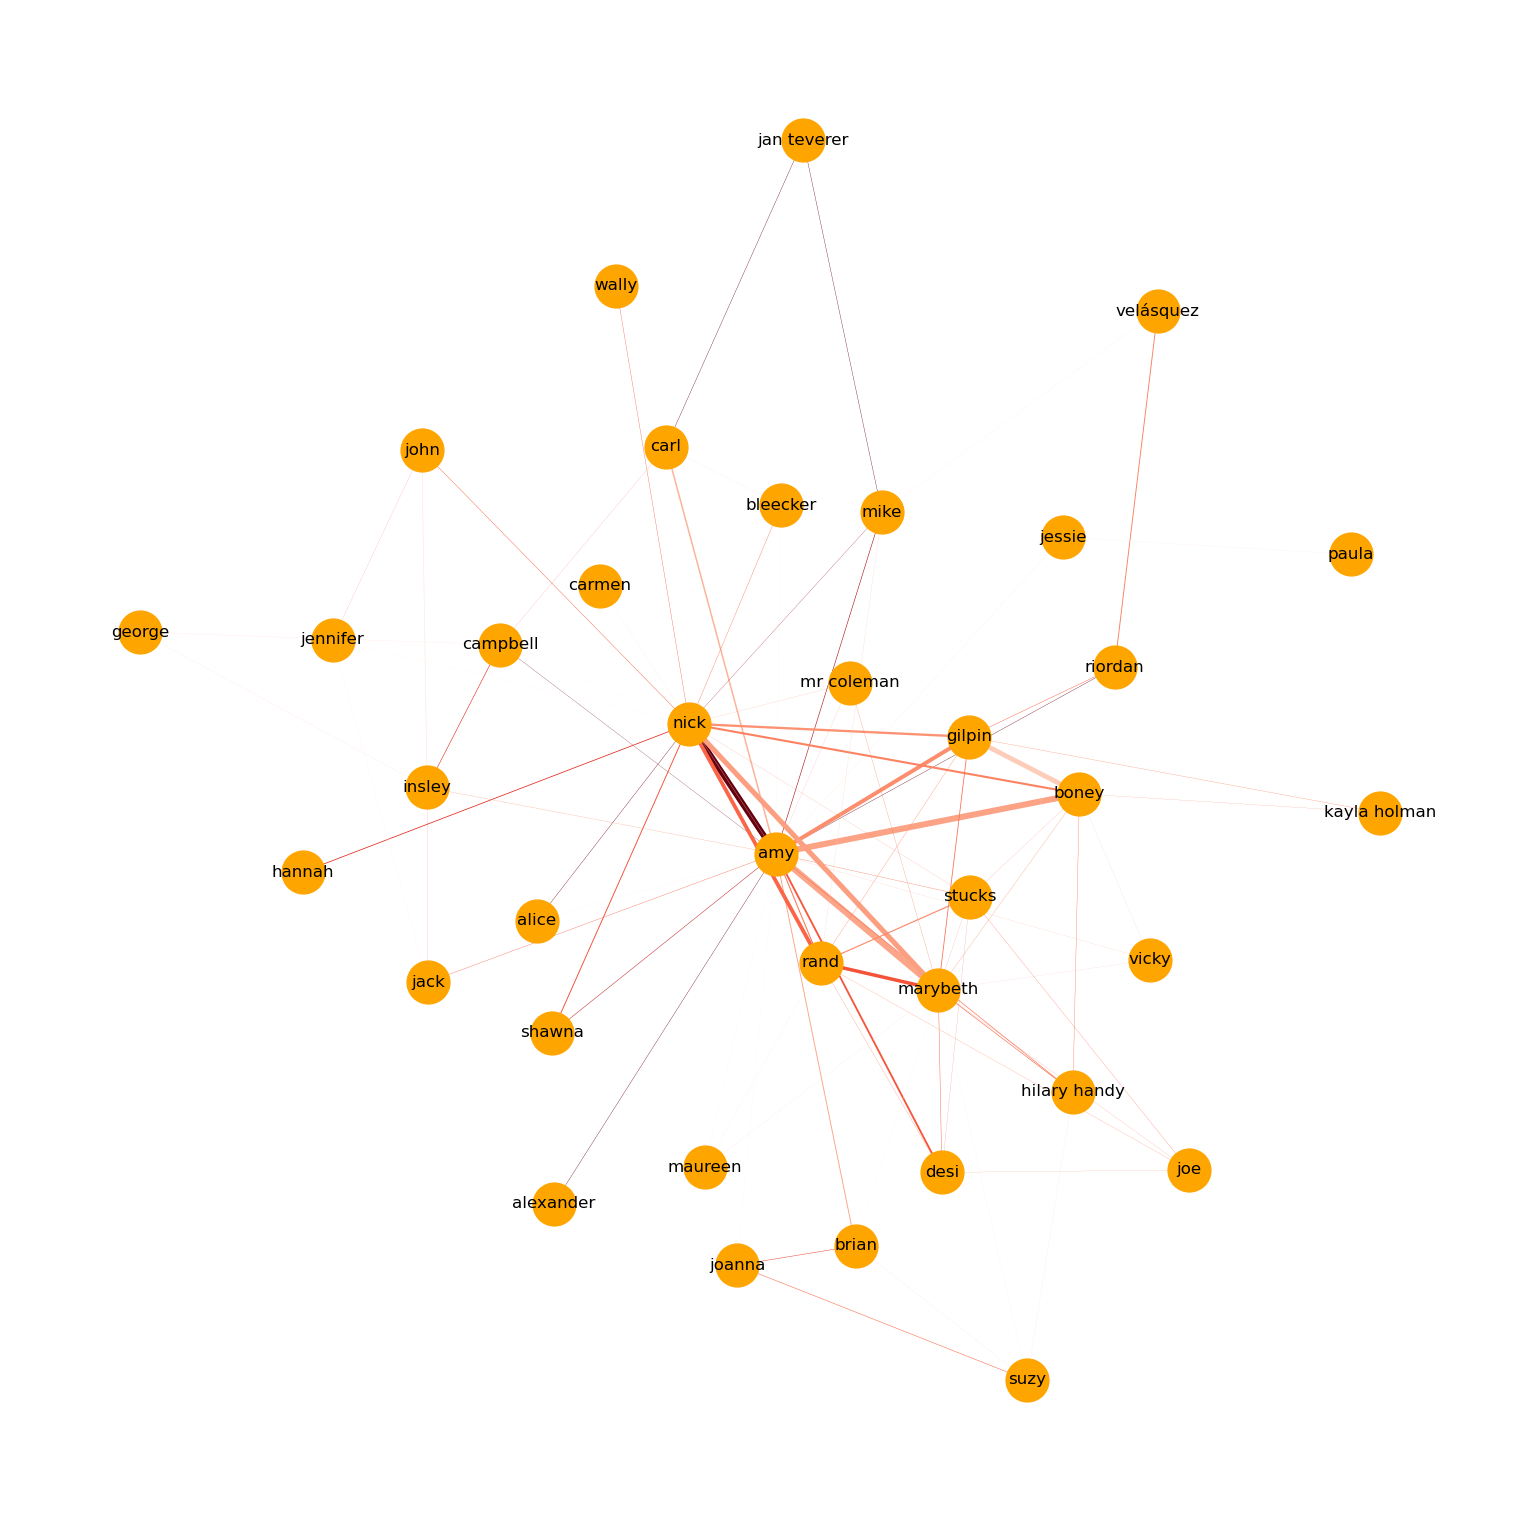

In [15]:
# change the coocurence ratio to better fit network aesthetics/readability
gg1_relationship_df_1['num_cooccurence'] = gg1_relationship_df_1['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg1_relationship_df_1
G = nx.from_pandas_edgelist(gg1_relationship_df_1, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

Although the character network does not denote which way the sentiment between characters flow, from the width and darkness of Amy and Nick's relationship, it can be understood that they have a negatively connotation between each other. While this is accurate for most of this section of the novel, the character network fails to capture the progression in their relationship from Amy Dunne's perspective— which starts off with positive sentiment factors. 

Additionally, the width signifying the many interactions between Boney and Amy fails to recognize that the characters never meet in this section. This relationship also flows one day and Boney gains knowledge on Amy's life before her dissapearance; however, Amy is unaware of Boney's existence. 

#### Boy Loses Girl (second half) <a class="anchor" id="cn_p1_ii"></a>

In [16]:
# create a relationship dataframe and print preview of results
gg1_relationship_df_2 = pd.DataFrame(create_char_relationships(gg1_char_entity_df_2.reset_index()))

# assign values based on number of relationships
gg1_relationship_df_2["num_cooccurence"] = 1
gg1_relationship_df_2 = gg1_relationship_df_2.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg1_relationship_df_2 = gg1_relationship_df_2.loc[gg1_relationship_df_2['source'] != gg1_relationship_df_2['target']] 

# take a look at the character relationship dataframe
gg1_relationship_df_2.head(10)

,source,target,sentiment_score,num_cooccurence
0,rand,stucks,0.000000,2
2,joe,rand,0.000000,1
3,joe,stucks,0.000000,3
4,amy,joe,0.088235,2
5,amy,stucks,0.000000,1
6,amy,melanie,0.000000,1
7,melanie,stucks,-0.222222,2
8,lonnie,melanie,-0.381818,2
9,joe,lonnie,-0.104318,6
11,lonnie,rand,-0.065965,10


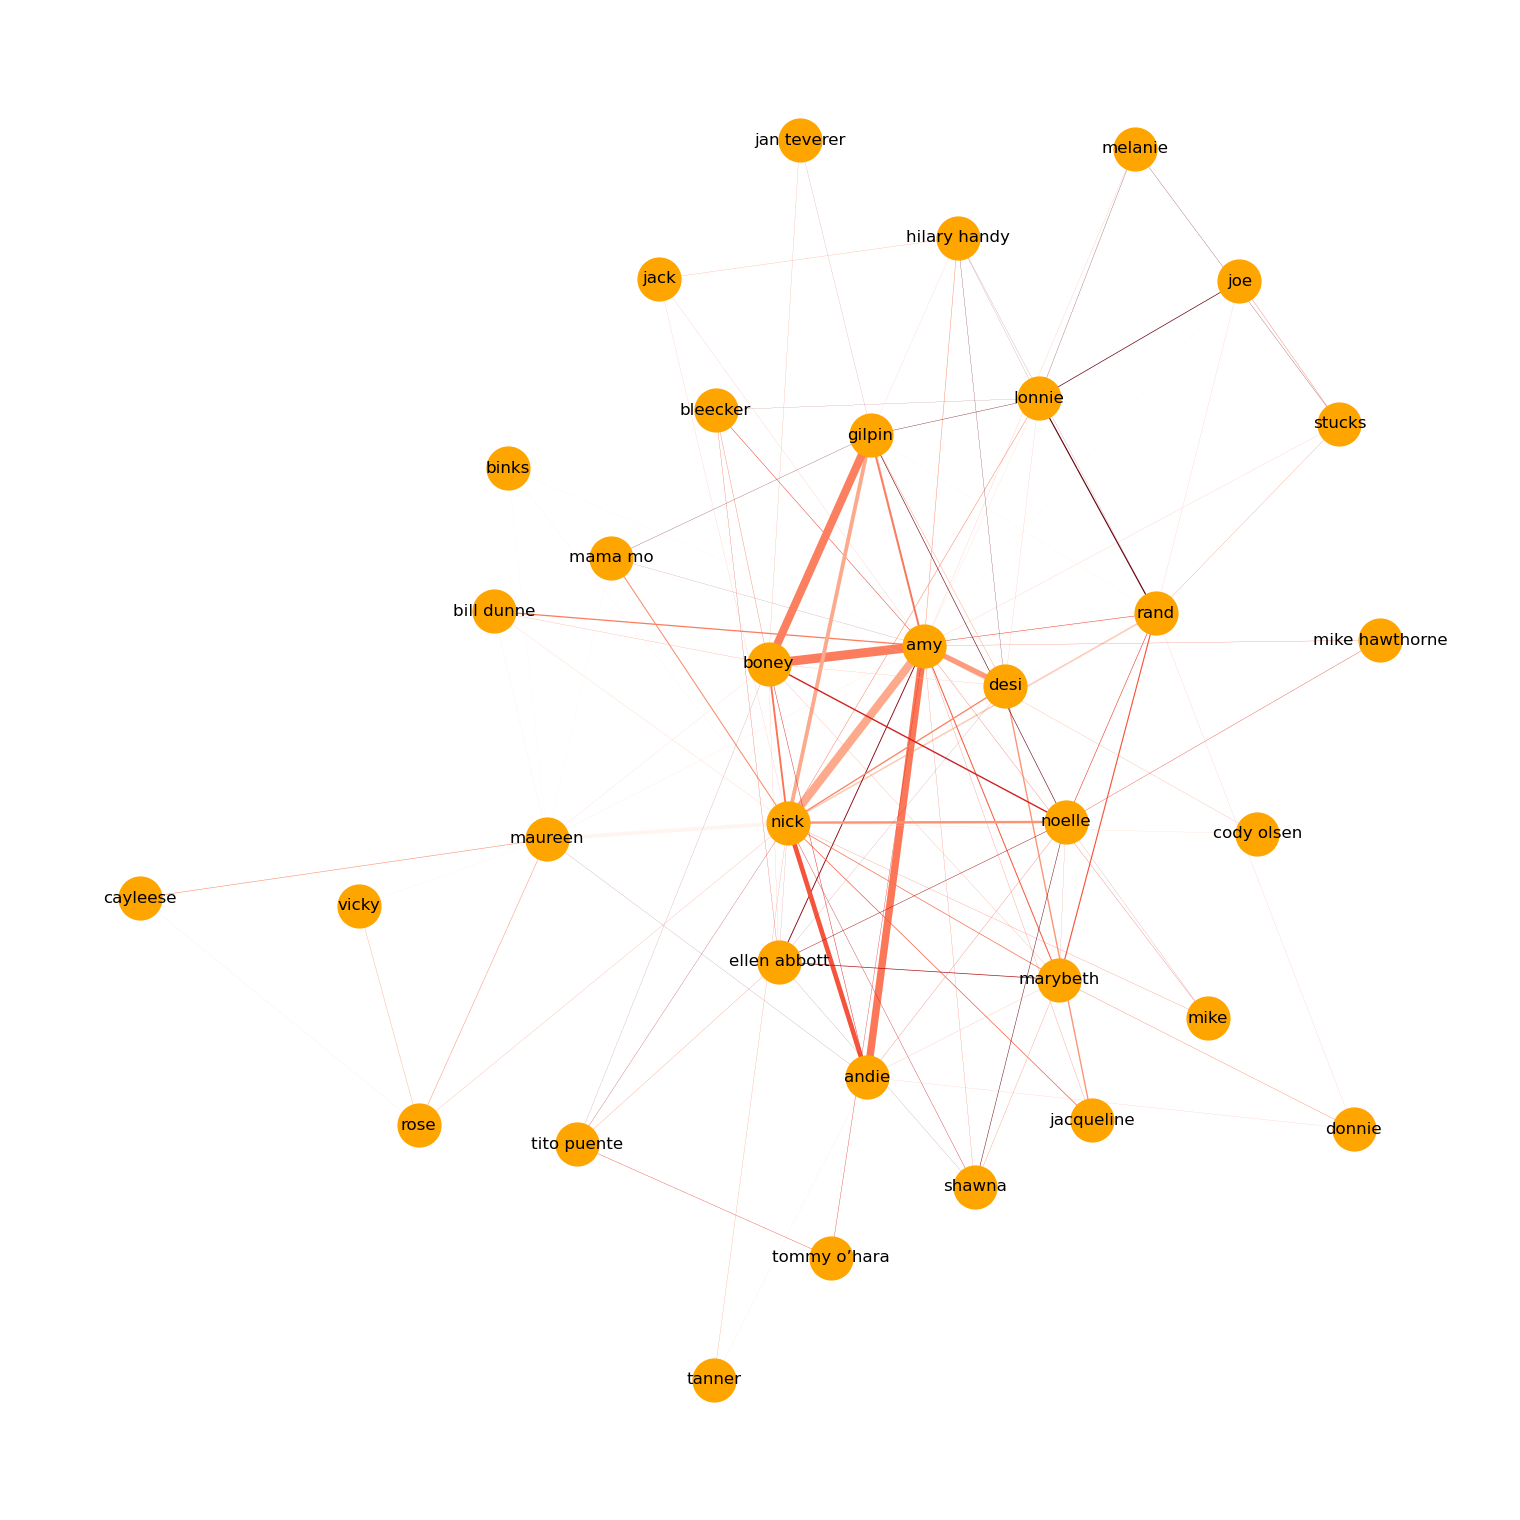

In [17]:
# change the coocurence ratio to better fit network aesthetics/readability
gg1_relationship_df_2['num_cooccurence'] = gg1_relationship_df_2['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg1_relationship_df_2
G = nx.from_pandas_edgelist(gg1_relationship_df_2, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

This character network depicts the relationship and growing disparities between Amy and Nick's relationship accurately. It can be seen that Nick and Amy interact less frequesntly and with fewer negatively-connotated incident. Meanwhile, a relationship between Nick and Andie is revealed. The police officers, Boney and Gilpin are established as partners which the network captures as well. 

However, there are still some drawbacks as Andie and Amy never interact and the passionate of their hatred for one another is not captured accurately by the edge color. As mentioned above in the previous character network, the character network fails to show the relationship flow from Boney to Amy, as Amy does not display any sentiments towards Boney in this section.  

#### Boy Loses Girl (entire network) <a class="anchor" id="cn_p1_i_ii"></a>

In [18]:
# create a relationship dataframe and print preview of results
gg1_relationship_df = pd.DataFrame(create_char_relationships(gg1_char_entity_df_1_2.reset_index()))

# assign values based on number of relationships
gg1_relationship_df["num_cooccurence"] = 1
gg1_relationship_df = gg1_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg1_relationship_df = gg1_relationship_df.loc[gg1_relationship_df['source'] != gg1_relationship_df['target']] 

# take a look at the character relationship dataframe
gg1_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.011595,121
1,amy,carmen,0.291538,2
2,carmen,nick,0.195197,2
3,alice,amy,0.024390,3
5,amy,carl,0.008045,13
7,amy,bleecker,0.029242,7
8,bleecker,carl,0.060334,4
10,amy,marybeth,0.005755,63
11,marybeth,nick,0.005278,50
12,amy,riordan,-0.018999,3


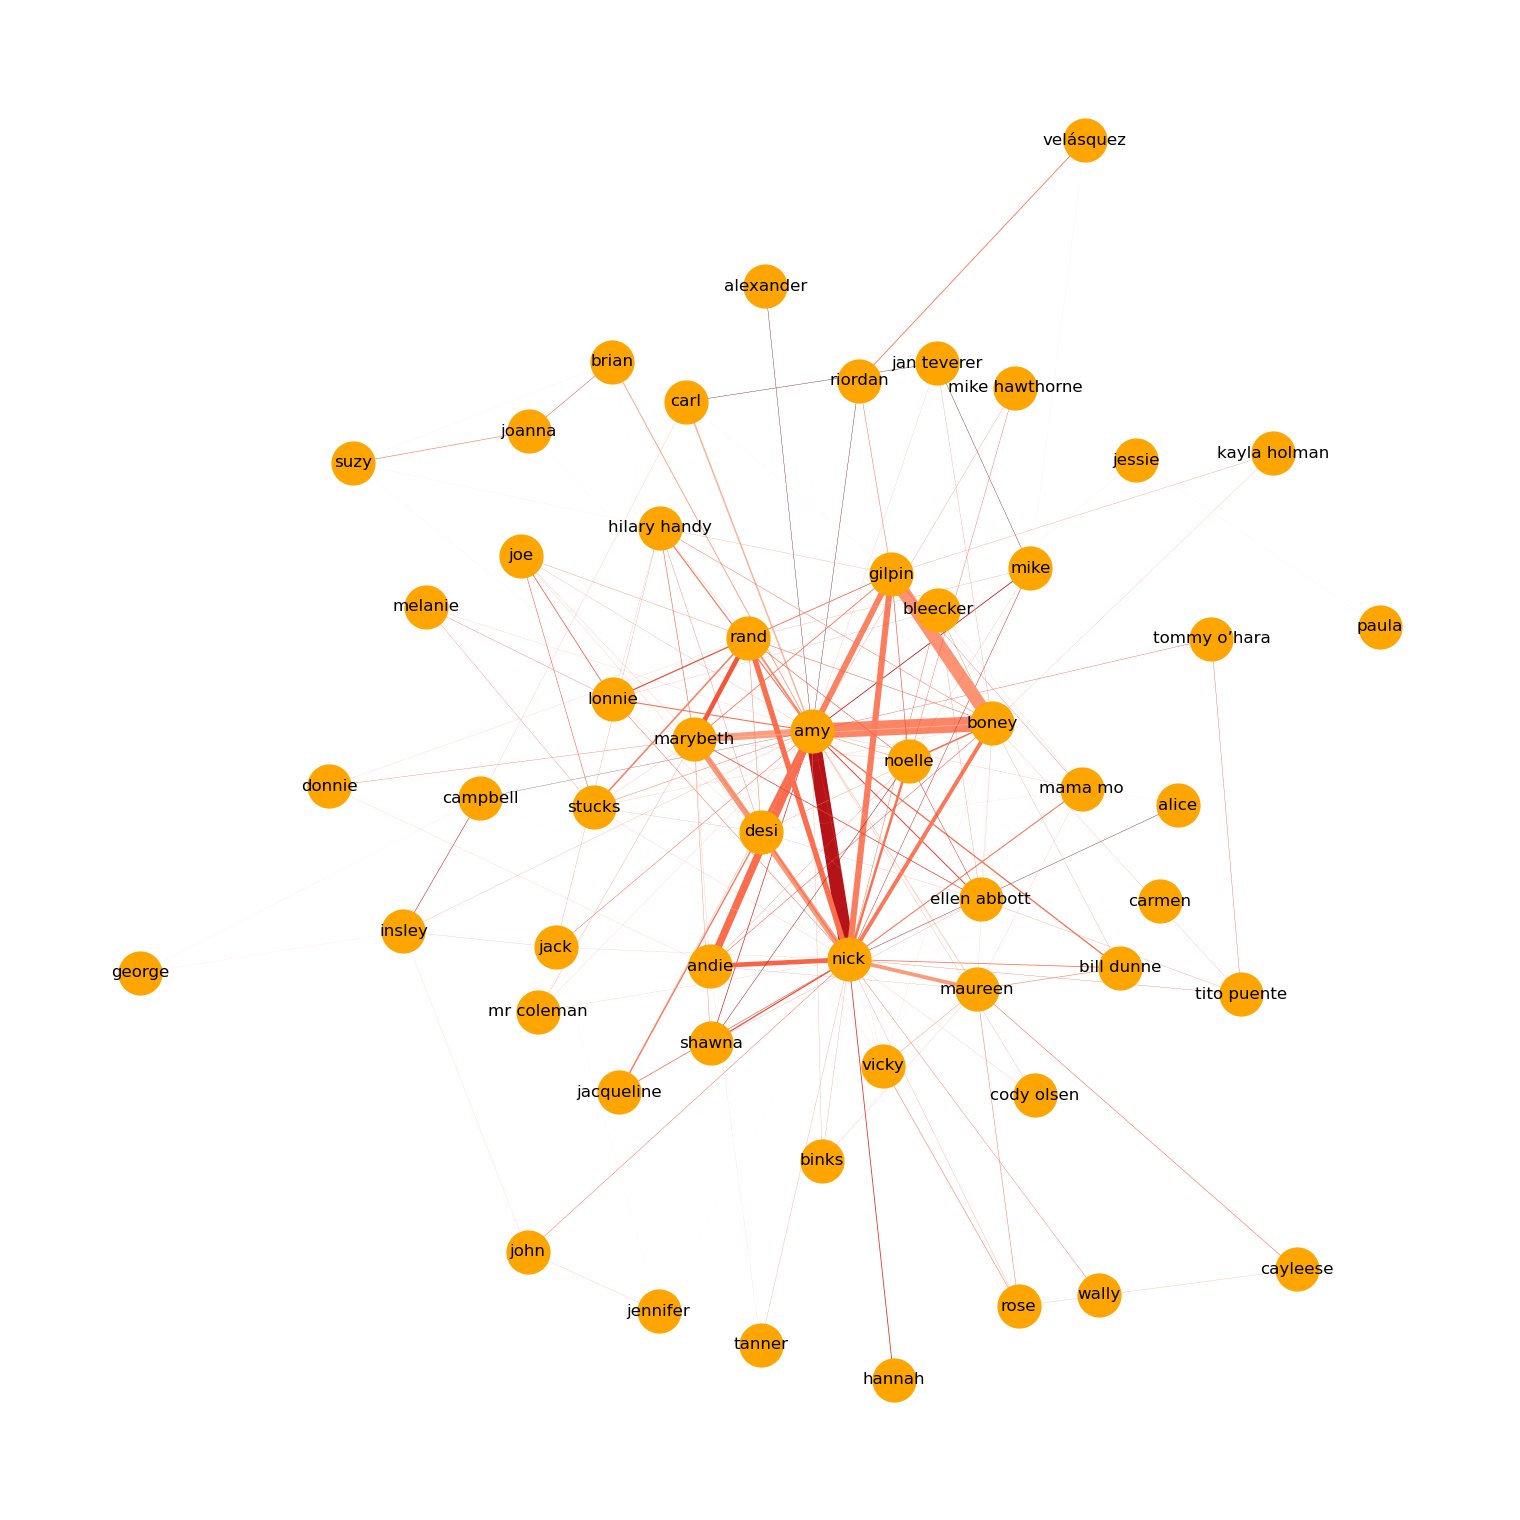

In [19]:
# change the coocurence ratio to better fit network aesthetics/readability
gg1_relationship_df['num_cooccurence'] = gg1_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg1_relationship_df
G = nx.from_pandas_edgelist(gg1_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

The combined character network of Part One reveals the foundations of the novel as the relationship between Nick and Amy Dunne. This network aids in establishing the characters as the driving points of the plot as the most interactions and negative sentiments are plotted between them. Similarly, both characters are aware of the other significant characters that play a large role in each others' lives. For example, Desi and Nick have encounters as well as Andie and Amy because of Amy's relationship with Nick and vice versa. 

This character network also sets the foundations for understanding Amy's disapearance as this is later revealed in the novel. Flynn emphasizes Amy and Nick's relationship as the centerpoint of the book, which this network captures. 

## Boy Meets Girl <a class="anchor" id="Boy_Meets_Girl"></a>

To understand how character networks change in this novel, we will proceed with plotting the second part of *Gone Girl* using a similar procedure as that for the previous section.

### Extracting Character Entities Using Name Entity Recognition

In [20]:
# load the second part of the book and run name entity recognition on it
gg2_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part2.txt")
gg2_text = open(gg2_book, encoding="utf8").read()
gg2_doc = ner(gg2_text)

In [21]:
# preview of the ner results
displacy.render(gg2_doc[0:716], style="ent", jupyter=True)

Because we've already filtered out a list of characters in the novel, we can directly continue with the character interactions.

In [22]:
gg2_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg2_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg2_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg2_char_entity_df = pd.DataFrame(gg2_char_entity_df)

# remove sentences without character entities
gg2_char_entity_df_1_2 = gg2_char_entity_df[gg2_char_entity_df['char_entities'].map(len) > 0]

The following code splits the dataframe in half so that we can conveniently generate separate character networks.

In [23]:
# process the first half of Part 2
len_gg2_char_entity_df = len(gg2_char_entity_df)
gg2_char_entity_df_1 = gg2_char_entity_df.iloc[:int(len_gg2_char_entity_df/2)]

# remove sentences without character entities
gg2_char_entity_df_1 = gg2_char_entity_df_1[gg2_char_entity_df_1['char_entities'].map(len) > 0]

In [24]:
# let's take a look at the dataframe so far
gg2_char_entity_df_1.head(10)

,sentence,char_entities
10,"(But, Amy, is, afraid, of, blood, ,, the, diar...",[amy]
14,"(I, told, Nick, probably, half, a, dozen, time...",[nick]
15,"(Nick, has, such, a, careless, memory, for, ot...",[nick]
28,"(Then, I, cleaned, it, up, as, poorly, as, Nic...",[nick]
30,"(The, living, room, looks, staged, ,, yet, the...",[amy]
47,"(Item, 29, :, Say, goodbye, to, Bleecker, .)",[bleecker]
53,"(Not, Diary, Amy, ,, who, is, a, work, of, fic...",[nick]
59,"(They, were, all, girls, ;, they, were, all, n...",[hope]
60,"(I, ’m, sure, it, was, my, father, ’s, suggest...",[marybeth]
72,"(When, I, remained, alive, ,, they, named, me,...",[amy]


In [25]:
# process the second half of Part 2
gg2_char_entity_df_2 = gg1_char_entity_df.iloc[int(len_gg2_char_entity_df/2)+1:]

# remove sentences without character entities
gg2_char_entity_df_2 = gg2_char_entity_df_2[gg2_char_entity_df_2['char_entities'].map(len) > 0]

In [26]:
# let's take a look at the dataframe so far
gg2_char_entity_df_2.head(10)

,sentence,char_entities
2306,"(So, it, pisses, me, off, ,, that, Nick, is, f...",[nick]
2308,"(I, realize, that, I, am, more, type, A, than,...",[nick]
2309,"(Nick, is, not, the, kind, of, guy, who, is, g...",[nick]
2315,"(And, Nick, ’s, not, doing, anything, anymore,...",[nick]
2317,"(I, know, ,, I, know, ,, I, know, that, losing...",[nick]
2323,"(I, never, called, it, a, trust, fund, before,...",[nick]
2327,"(Nick, makes, fun, ,, but, I, think, it, ’s, a...",[nick]
2345,"(‘, The, fact, of, the, matter, is, ,, we, ’ve...",[marybeth]
2349,"(We, just, kept, thinking, the, next, Amy, boo...",[amy]
2355,"(‘, We, ’re, basically, broke, ,, ’, Rand, say...",[rand]


### Character Networks

Like before, we'll construct a character network based off of sentiment scores and number of interactions.

#### Boy Meets Girl (first half) <a class="anchor" id="cn_p2_i"></a>

In [27]:
# create a relationship dataframe and print preview of results
gg2_relationship_df_1 = pd.DataFrame(create_char_relationships(gg2_char_entity_df_1.reset_index()))

# assign values based on number of relationships
gg2_relationship_df_1["num_cooccurence"] = 1
gg2_relationship_df_1 = gg2_relationship_df_1.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg2_relationship_df_1 = gg2_relationship_df_1.loc[gg2_relationship_df_1['source'] != gg2_relationship_df_1['target']] 

# take a look at the character relationship dataframe
gg2_relationship_df_1.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.085680,50
1,amy,bleecker,-0.200000,2
2,bleecker,nick,-0.086503,5
3,bleecker,hope,0.285714,1
4,hope,nick,0.285714,1
5,hope,marybeth,0.930556,2
6,marybeth,nick,0.218788,13
7,amy,hope,1.111111,1
8,amy,lydia,0.581818,2
9,lydia,marybeth,0.387879,3


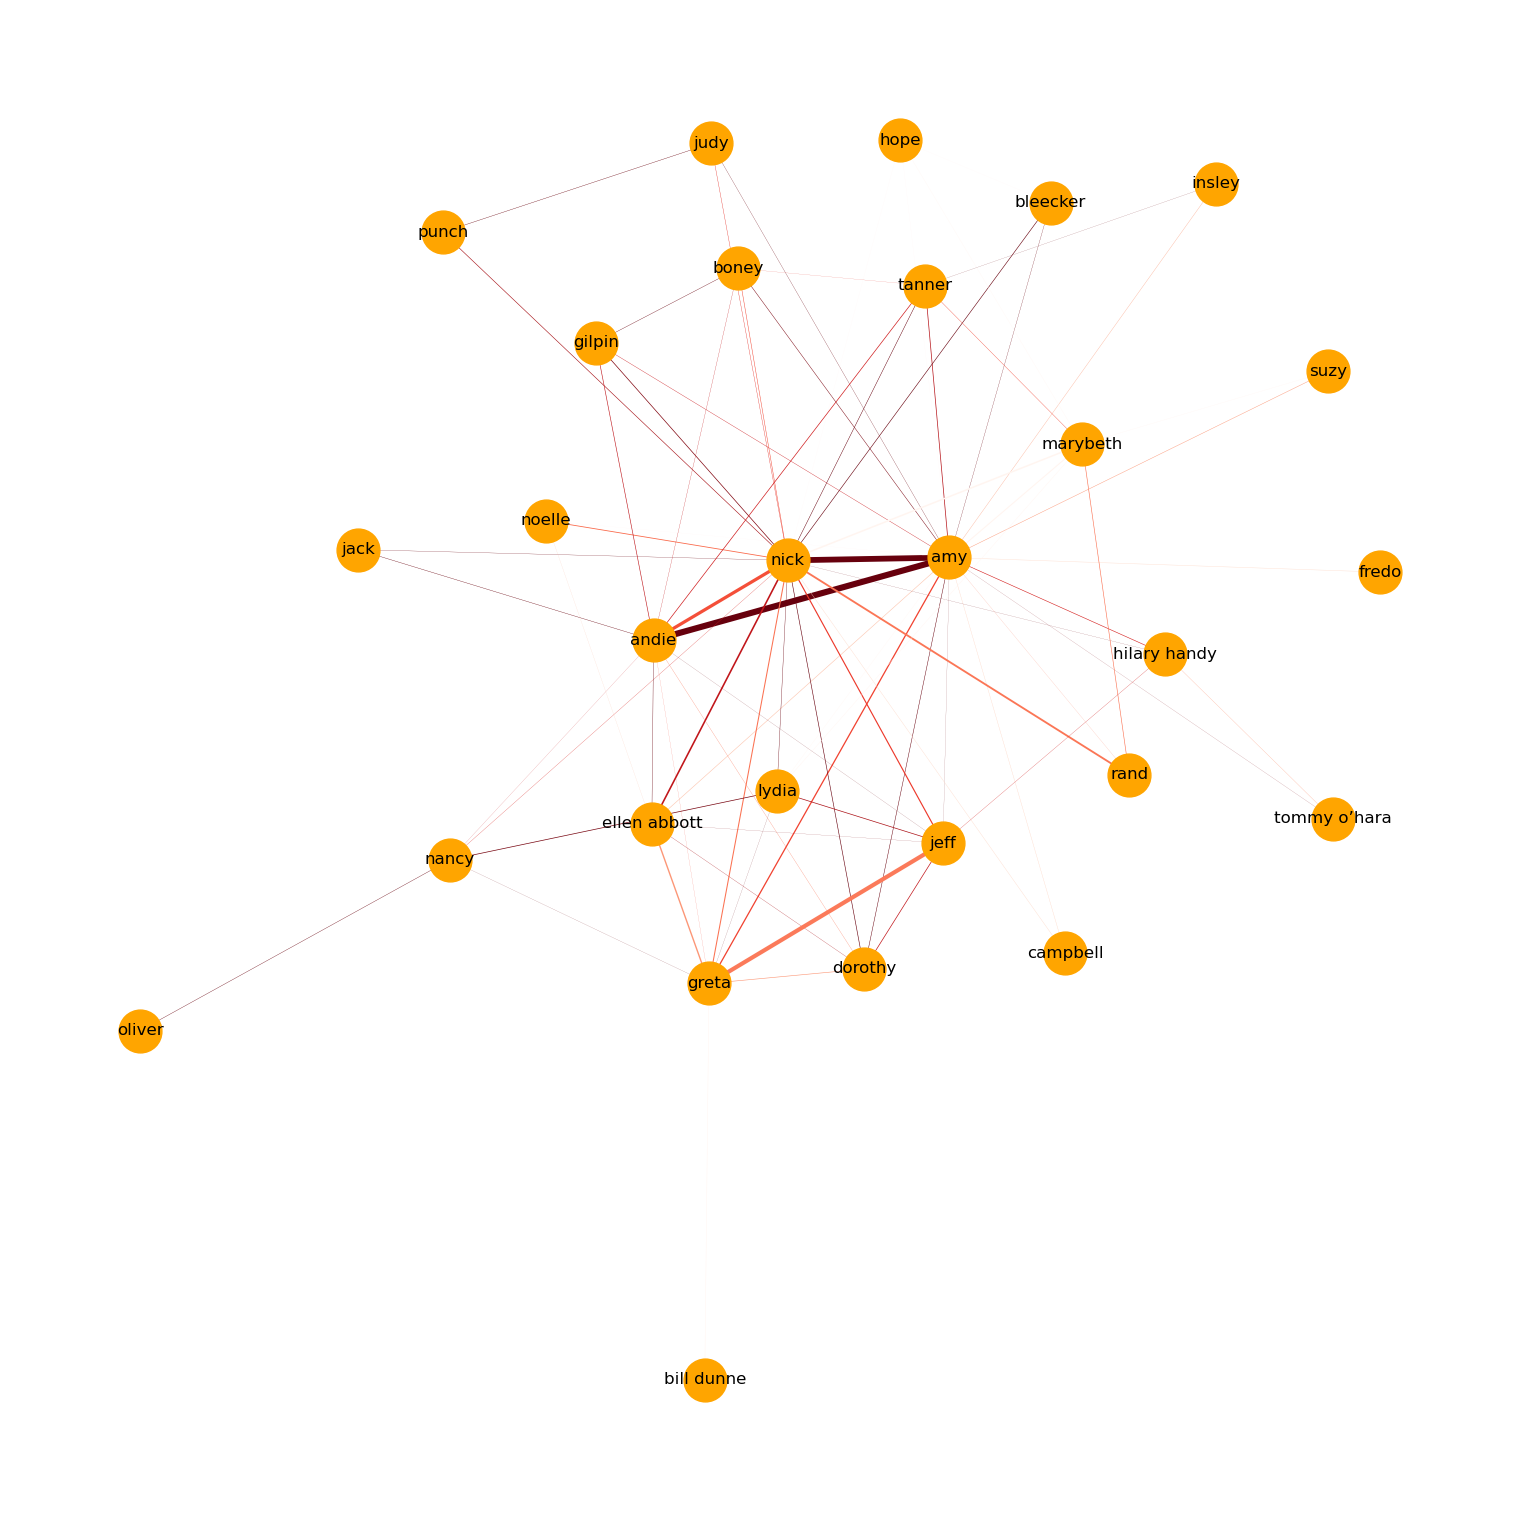

In [28]:
# change the coocurence ratio to better fit network aesthetics/readability
gg2_relationship_df_1['num_cooccurence'] = gg2_relationship_df_1['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg2_relationship_df_1
G = nx.from_pandas_edgelist(gg2_relationship_df_1, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

As Greta and Jeff's relationship is established alongside the main happenings of the novel, this network captures the infidelity between characters. From the edge colors, it can be said that while Nick and Amy, and Andie and Amy have negative sentiments to one another, Andie and Nick have a positively-connotated relationship. Andie has joined as a focal point of the narrative alongside Nick and Amy. 

#### Boy Meets Girl (second half) <a class="anchor" id="cn_p2_ii"></a>

In [29]:
# create a relationship dataframe and print preview of results
gg2_relationship_df_2 = pd.DataFrame(create_char_relationships(gg2_char_entity_df_2.reset_index()))

# assign values based on number of relationships
gg2_relationship_df_2["num_cooccurence"] = 1
gg2_relationship_df_2 = gg2_relationship_df_2.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg2_relationship_df_2 = gg2_relationship_df_2.loc[gg2_relationship_df_2['source'] != gg2_relationship_df_2['target']] 

# take a look at the character relationship dataframe
gg2_relationship_df_2.head(10)

,source,target,sentiment_score,num_cooccurence
0,marybeth,nick,0.140680,18
1,amy,marybeth,0.078337,23
2,marybeth,rand,0.001283,21
3,amy,nick,-0.001816,82
4,nick,rand,-0.015707,21
7,amy,hilary handy,-0.091673,7
8,hilary handy,marybeth,-0.079545,4
9,amy,boney,0.002409,89
10,boney,marybeth,0.040104,5
12,boney,gilpin,0.004372,73


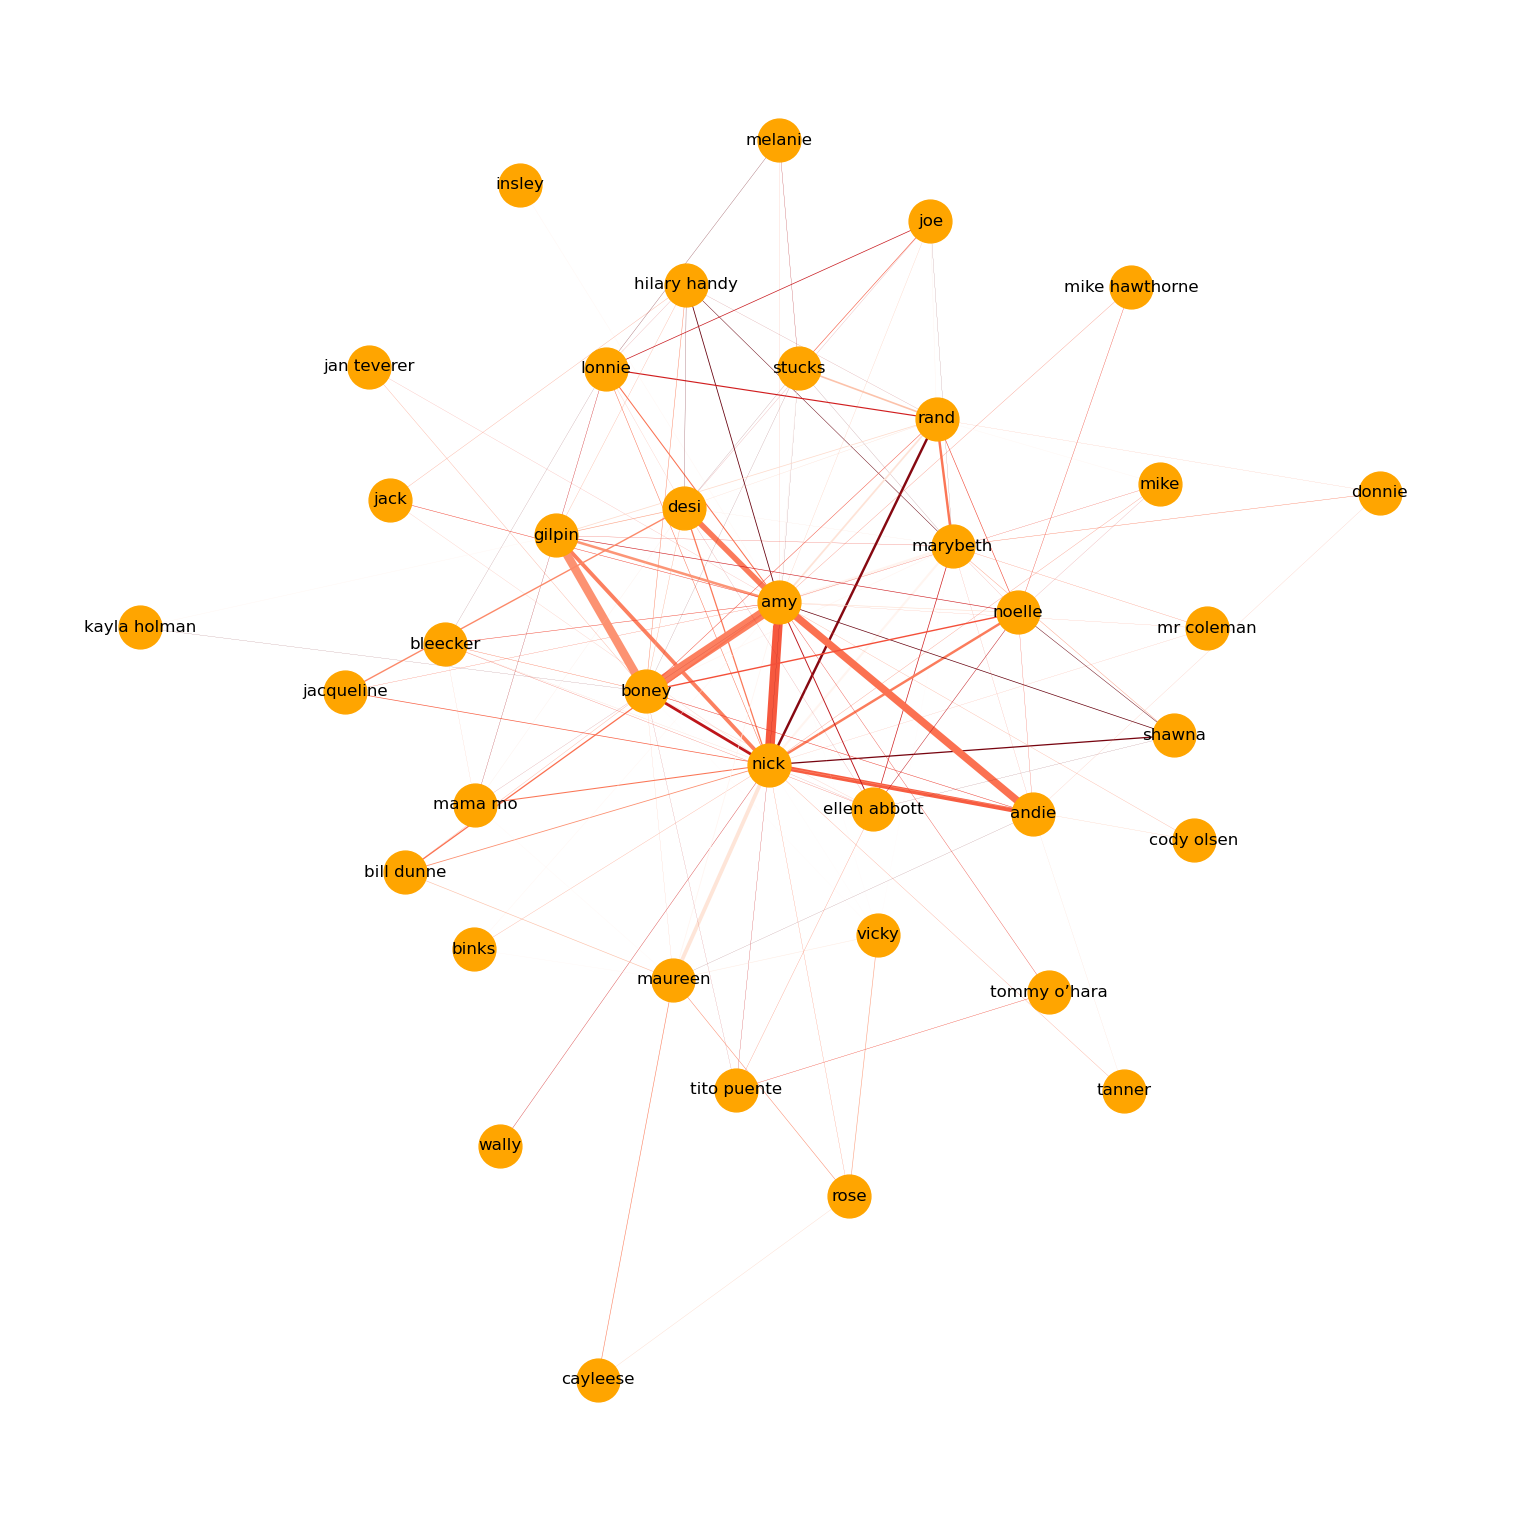

In [30]:
# change the coocurence ratio to better fit network aesthetics/readability
gg2_relationship_df_2['num_cooccurence'] = gg2_relationship_df_2['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg2_relationship_df_2
G = nx.from_pandas_edgelist(gg2_relationship_df_2, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

Nick and Amy return to being the focal points of the narrative as shown by this character network. The sentiments towards one another becomes less negatively-driven, while Boney returns as an observer to their dynamic. Although the network does not capture this element, Boney has an emotional and parasocial relationship with Amy, hence the edge color and width between them. Meanwhile, the interactions between Boney and Nick decrease and their relationship strains. 

#### Boy Meets Girl (entire network) <a class="anchor" id="cn_p2_i_ii"></a>

In [31]:
# create a relationship dataframe and print preview of results
gg2_relationship_df = pd.DataFrame(create_char_relationships(gg2_char_entity_df_1_2.reset_index()))

# assign values based on number of relationships
gg2_relationship_df["num_cooccurence"] = 1
gg2_relationship_df = gg2_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg2_relationship_df = gg2_relationship_df.loc[gg2_relationship_df['source'] != gg2_relationship_df['target']] 

# take a look at the character relationship dataframe
gg2_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.045381,92
1,amy,bleecker,-0.200000,2
2,bleecker,nick,-0.086503,5
3,bleecker,hope,0.285714,1
4,hope,nick,0.285714,1
5,hope,marybeth,0.930556,2
6,marybeth,nick,0.218788,13
7,amy,hope,1.111111,1
8,amy,lydia,0.581818,2
9,lydia,marybeth,0.387879,3


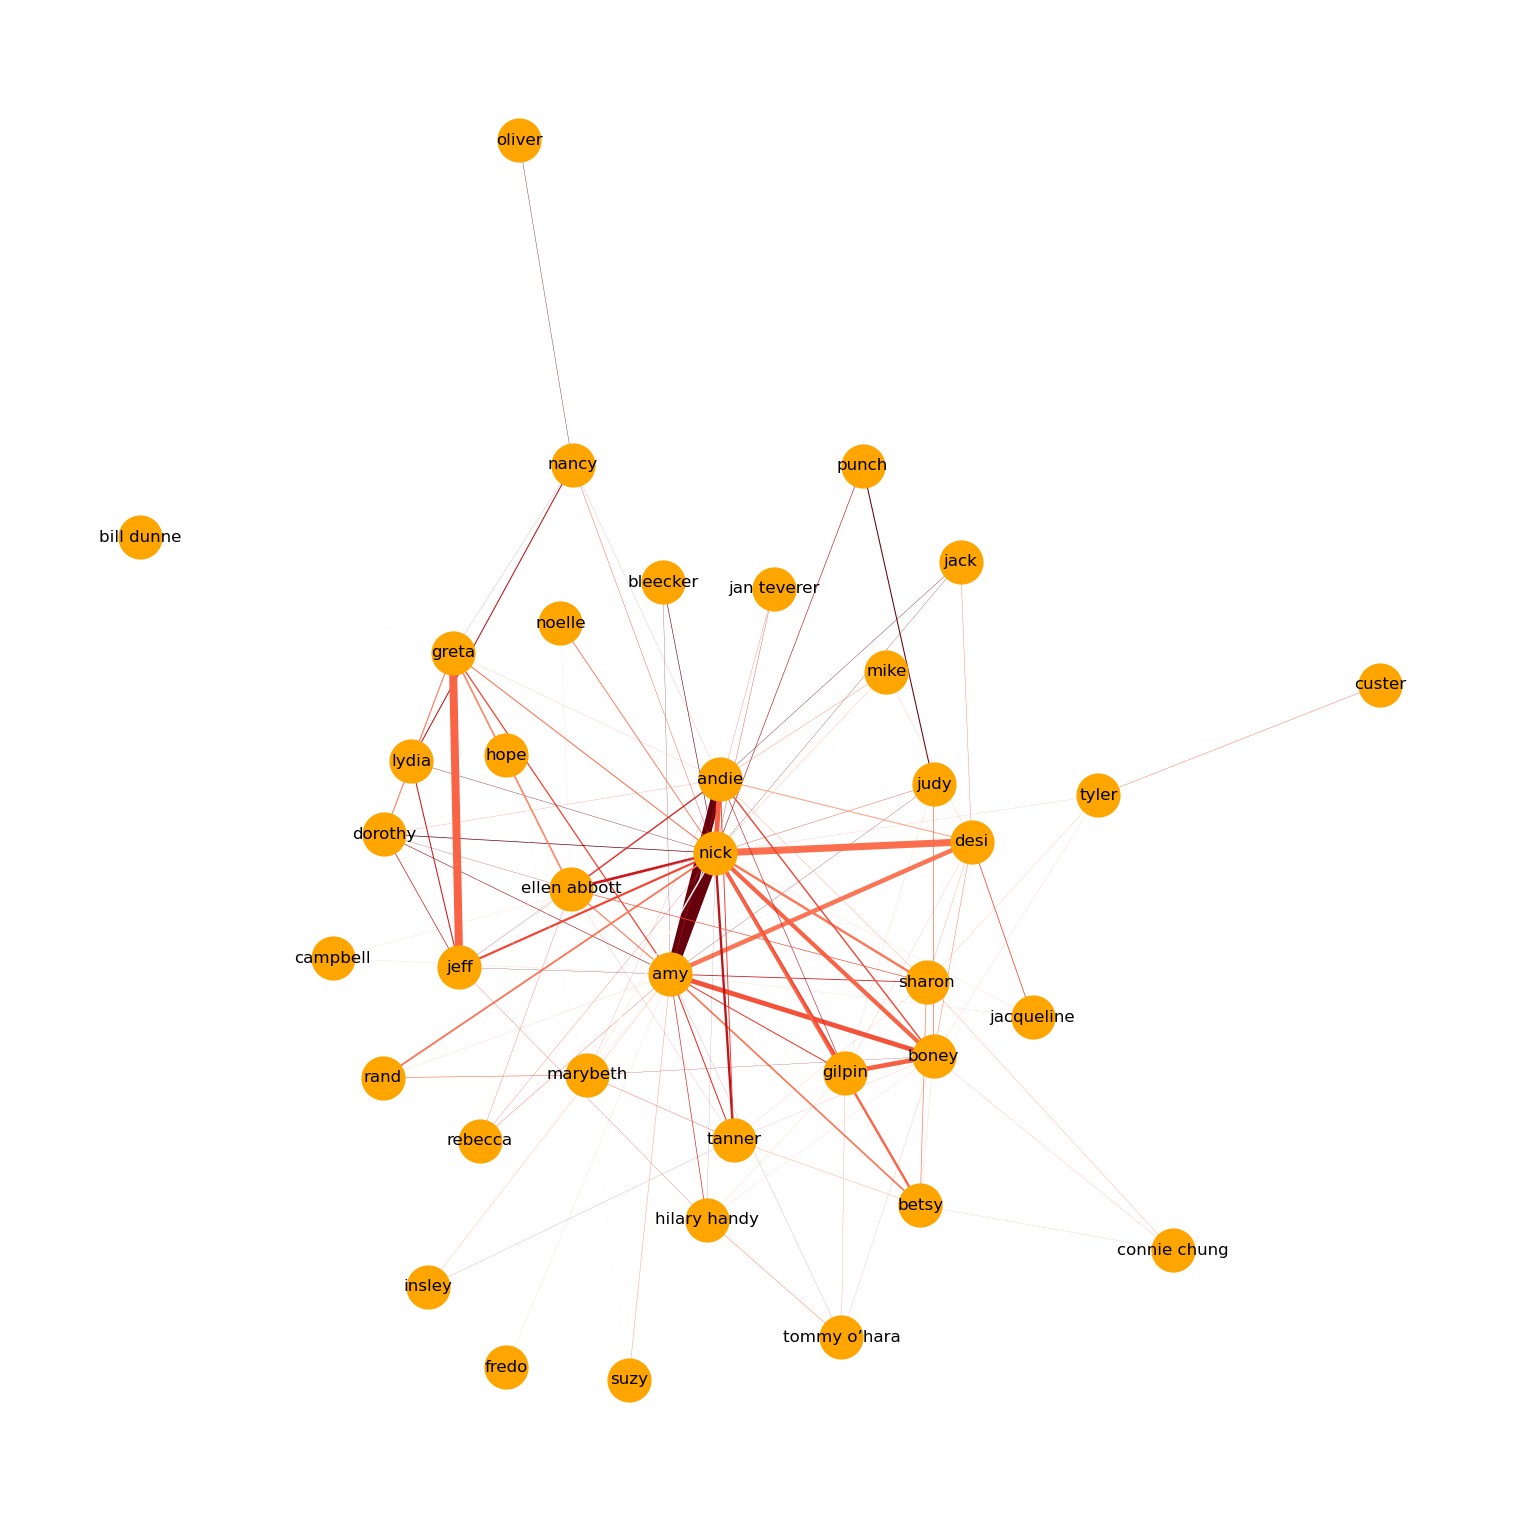

In [32]:
# change the coocurence ratio to better fit network aesthetics/readability
gg2_relationship_df['num_cooccurence'] = gg2_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg2_relationship_df
G = nx.from_pandas_edgelist(gg2_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

From the character networks of Part Two, it can be said that the negative relationships between Nick and Amy, and Amy and Andie are the driving points of the other relationships. Andie and Nick maintain a generally positively sentimented relationship and Nick furthers his relationship with Desi, which is influenced by the connection between Amy and Desi. Jeff and Boney maintain a strong relationship due to their employment as partners; however, there is some turmoil between them. 

This section reveals the twist in Amy's disappearance, which can be connected to the intensity of the relationships between Amy, Nick, and Andie. As Nick and Amy are the storytellers of the novel, they remain the focal points of the network. 

## Boy Gets Girl Back <a class="anchor" id="Boy_Gets_Girl_Back"></a>

Finally, we will plot the last section of the novel. Again, we'll use the same procedures.

### Extracting Character Entities Using Name Entity Recognition

In [33]:
# load the third part of the book and run name entity recognition on it
gg3_book = (r"C:\Users\tracypaige\LTCS180\txt_gillian_flynn\gone_girl_part3.txt")
gg3_text = open(gg3_book, encoding="utf8").read()
gg3_doc = ner(gg3_text)

In [34]:
# preview of the ner results
displacy.render(gg3_doc[0:679], style="ent", jupyter=True)

Because we've already filtered out a list of characters in the novel, we can directly continue with the character interactions.

In [35]:
gg3_char_entity_df = []

# loop through sentences, filter and store character entity list for each sentence
for sent in gg3_doc.sents:
    # make sure to filter differences by converting to lowercase
    char_entity_list = [ent.text.lower() for ent in sent.ents
                        if ent.text.lower() in list(gone_girl_characters_df['name'])]
    gg3_char_entity_df.append({"sentence": sent, "char_entities": char_entity_list})

# convert list of data into dataframe
gg3_char_entity_df = pd.DataFrame(gg3_char_entity_df)

# remove sentences without character entities
gg3_char_entity_df_1_2 = gg3_char_entity_df[gg3_char_entity_df['char_entities'].map(len) > 0]

The following code splits the dataframe in half so that we can conveniently generate separate character networks.

In [36]:
# process the first half of Part 3
len_gg3_char_entity_df = len(gg3_char_entity_df)
gg3_char_entity_df_1 = gg3_char_entity_df.iloc[:int(len_gg3_char_entity_df/2)]

# remove sentences without character entities
gg3_char_entity_df_1 = gg3_char_entity_df_1[gg3_char_entity_df_1['char_entities'].map(len) > 0]

In [37]:
# let's take a look at the dataframe so far
gg3_char_entity_df_1.head(10)

,sentence,char_entities
0,"(PART, THREE, \n\n, BOY, GETS, GIRL, BACK, \n\...",[nick]
6,"(Boney, might, have, put, a, good, word, in, f...",[boney]
17,"(Tanner, had, a, team, of, five, detectives, t...",[amy]
20,"(Every, day, for, weeks, ,, I, ’d, done, my, l...","[amy, rebecca]"
21,"((, Rebecca, ,, at, least, ,, had, remained, l...",[rebecca]
22,"(In, the, videos, ,, I, wore, clothes, Amy, ha...",[amy]
30,"(I, finished, my, evening, taping, to, Amy, .)",[amy]
31,"(I, was, wearing, a, green, shirt, she, liked,...",[amy]
35,"(Always, ending, with, Come, home, to, me, ,, ...",[amy]
61,"(The, cameras, were, blasting, us, ,, the, rep...",[amy]


In [38]:
# process the second half of Part 3
gg3_char_entity_df_2 = gg3_char_entity_df.iloc[int(len_gg3_char_entity_df/2)+1:]

# remove sentences without character entities
gg3_char_entity_df_2 = gg3_char_entity_df_2[gg3_char_entity_df_2['char_entities'].map(len) > 0]

In [39]:
# let's take a look at the dataframe so far
gg3_char_entity_df_2.head(10)

,sentence,char_entities
716,"(I, plunged, into, the, dark, daydream, I, ’d,...",[amy]
720,"(I, turned, around, ,, and, Amy, was, on, the,...",[amy]
721,"(‘, Play, nice, ,, Nick, ., ’, \n\n\n\n\n\n)",[nick]
728,"(I, know, Nick, ca, n’t, lie, like, that, .)",[nick]
749,"(‘, No, ,, Amy, ., ’, \n\n, ‘, I, can, ruin, y...","[amy, nick]"
750,"(‘, You, already, did, ,, Amy, ., ’)",[amy]
762,"(We, ’re, a, sick, ,, fucking, toxic, Möbius, ...",[amy]
766,"(You, do, n’t, really, love, me, ,, Amy, .)",[amy]
770,"(‘, I, wo, n’t, divorce, you, ,, Nick, .)",[nick]
775,"(‘, Think, about, it, ,, Amy, ,, how, bad, we,...",[amy]


### Character Networks

Like before, we'll construct a character network based off of sentiment scores and number of interactions.

#### Boy Gets Girl Back (first half) <a class="anchor" id="cn_p3_i"></a>

In [40]:
# create a relationship dataframe and print preview of results
gg3_relationship_df_1 = pd.DataFrame(create_char_relationships(gg3_char_entity_df_1.reset_index()))

# assign values based on number of relationships
gg3_relationship_df_1["num_cooccurence"] = 1
gg3_relationship_df_1 = gg3_relationship_df_1.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg3_relationship_df_1 = gg3_relationship_df_1.loc[gg3_relationship_df_1['source'] != gg3_relationship_df_1['target']] 

# take a look at the character relationship dataframe
gg3_relationship_df_1.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,boney,0.354752,5
1,boney,nick,0.387402,5
2,boney,rebecca,0.000000,1
3,amy,rebecca,0.411111,3
5,amy,desi,-0.028561,26
6,desi,judy,-0.030239,6
7,amy,judy,-0.152886,3
9,judy,nick,-0.000313,6
10,nick,rand,0.188170,4
12,andie,nick,0.333333,1


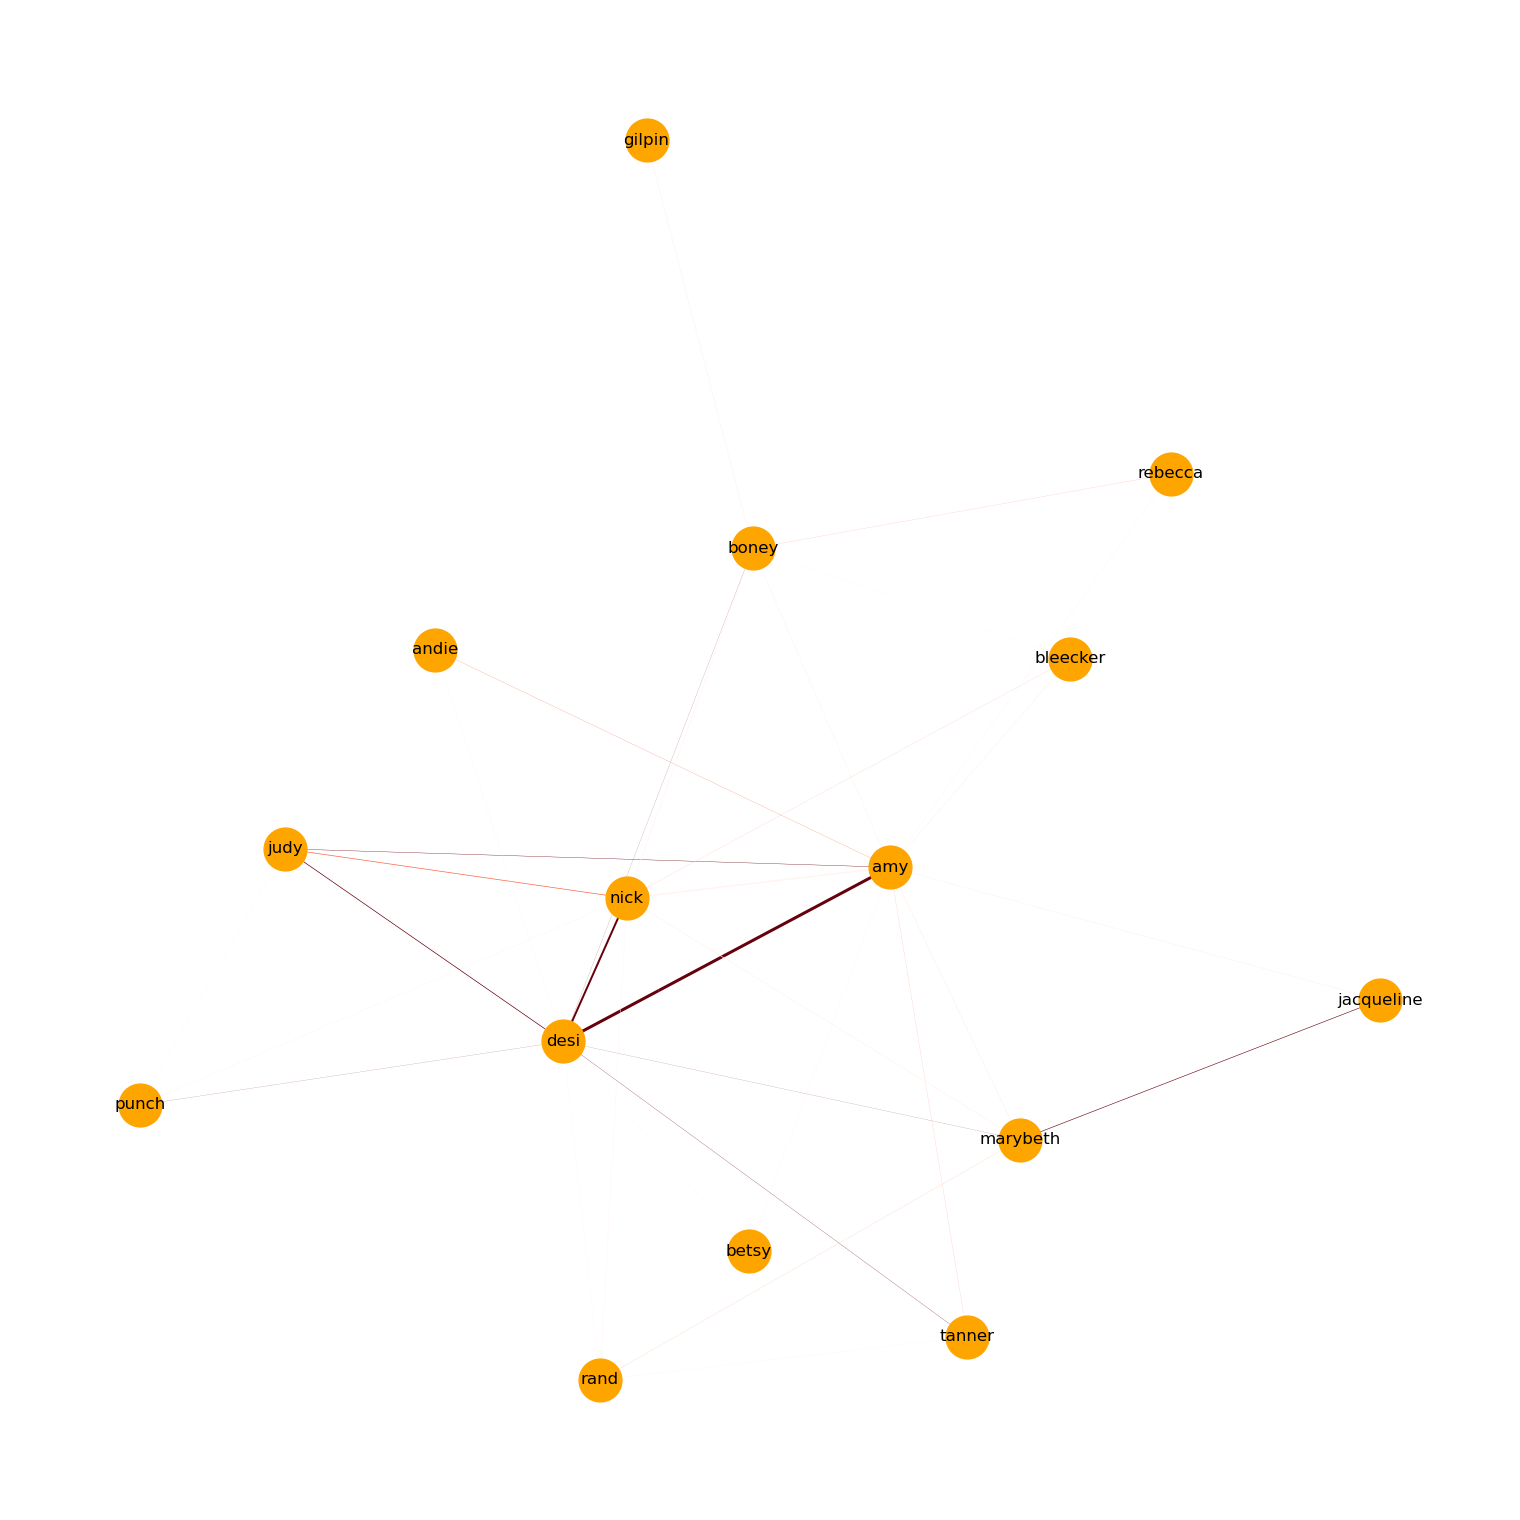

In [41]:
# change the coocurence ratio to better fit network aesthetics/readability
gg3_relationship_df_1['num_cooccurence'] = gg3_relationship_df_1['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg3_relationship_df_1
G = nx.from_pandas_edgelist(gg3_relationship_df_1, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

As the edge width is limited in this character network, while the edge colors are dark, the network suggests minimal but negatively-charged interactions between Desi and Amy, and Desi and Nick. 

The complexities of Desi's character can be better grasped through a close reading of the text, but this network suggests an antagonistic nature to Desi's relationship with the two main characters. 

#### Boy Gets Girl Back (second half) <a class="anchor" id="cn_p3_ii"></a>

In [42]:
# create a relationship dataframe and print preview of results
gg3_relationship_df_2 = pd.DataFrame(create_char_relationships(gg3_char_entity_df_2.reset_index()))

# assign values based on number of relationships
gg3_relationship_df_2["num_cooccurence"] = 1
gg3_relationship_df_2 = gg3_relationship_df_2.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg3_relationship_df_2 = gg3_relationship_df_2.loc[gg3_relationship_df_2['source'] != gg3_relationship_df_2['target']] 

# take a look at the character relationship dataframe
gg3_relationship_df_2.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.030929,34
3,amy,marybeth,-0.027778,1
4,marybeth,nick,-0.044584,3
5,boney,nick,-0.019507,14
6,boney,greta,0.013279,2
7,greta,jeff,0.047182,5
8,jeff,nick,0.029908,4
9,desi,greta,0.069784,3
12,amy,boney,-0.010976,18
13,boney,mia,0.000000,2


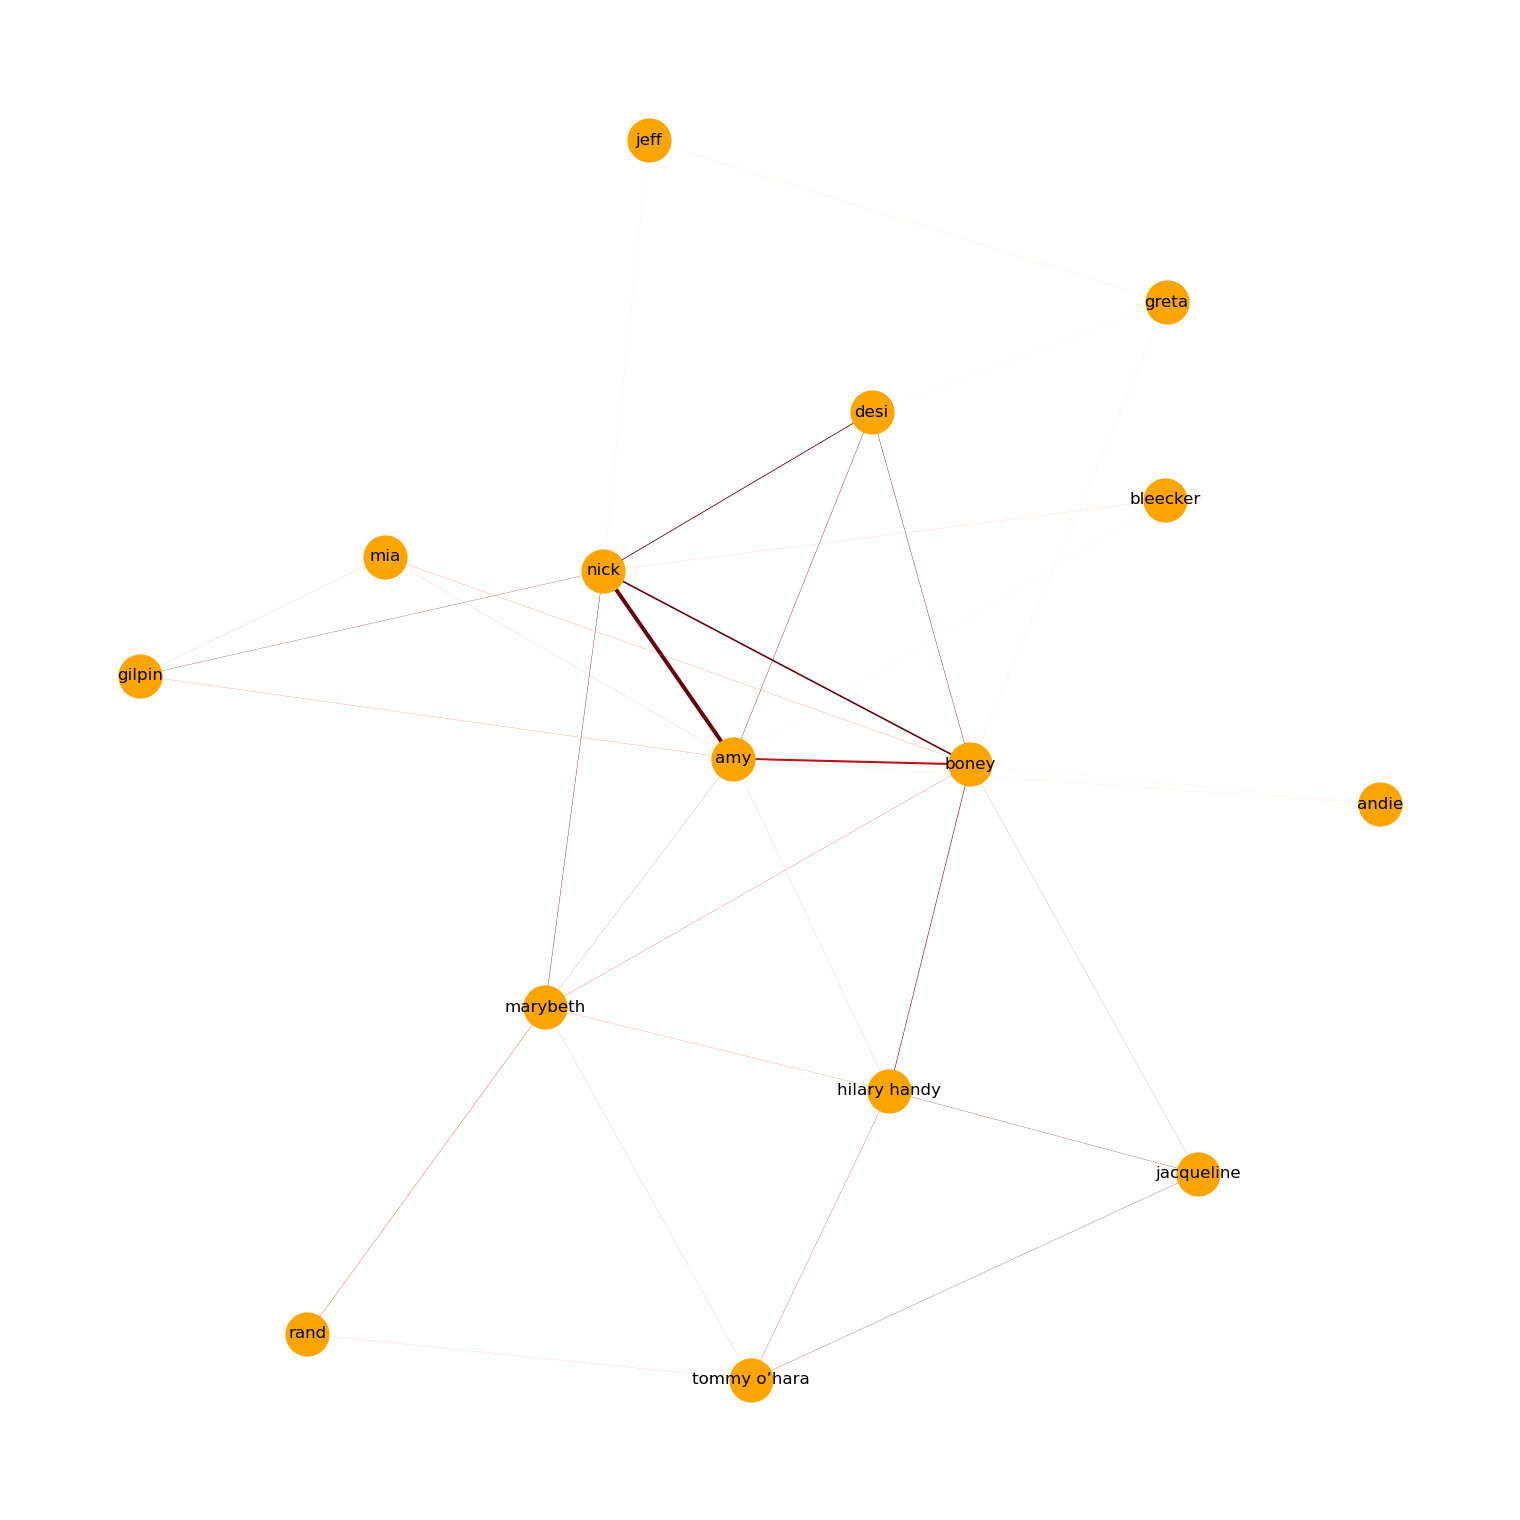

In [43]:
# change the coocurence ratio to better fit network aesthetics/readability
gg3_relationship_df_2['num_cooccurence'] = gg3_relationship_df_2['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg3_relationship_df_2
G = nx.from_pandas_edgelist(gg3_relationship_df_2, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

Amy and Nick remain at the center of the story. The darkness of Desi's edge colors suggests a negative relationship with all other characters. Additionally, Nick's edge colors are dark with the characters he interacts most with, displaying a negative association with his character as well. 

#### Boy Gets Girl Back (entire network) <a class="anchor" id="cn_p3_i_ii"></a>

In [44]:
# create a relationship dataframe and print preview of results
gg3_relationship_df = pd.DataFrame(create_char_relationships(gg3_char_entity_df_1_2.reset_index()))

# assign values based on number of relationships
gg3_relationship_df["num_cooccurence"] = 1
gg3_relationship_df = gg3_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg3_relationship_df = gg3_relationship_df.loc[gg3_relationship_df['source'] != gg3_relationship_df['target']] 

# take a look at the character relationship dataframe
gg3_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,boney,0.074015,23
1,boney,nick,0.097926,19
2,boney,rebecca,0.000000,1
3,amy,rebecca,0.411111,3
5,amy,desi,-0.027911,29
6,desi,judy,-0.030239,6
7,amy,judy,-0.152886,3
9,judy,nick,-0.000313,6
10,nick,rand,0.188170,4
12,andie,nick,0.333333,1


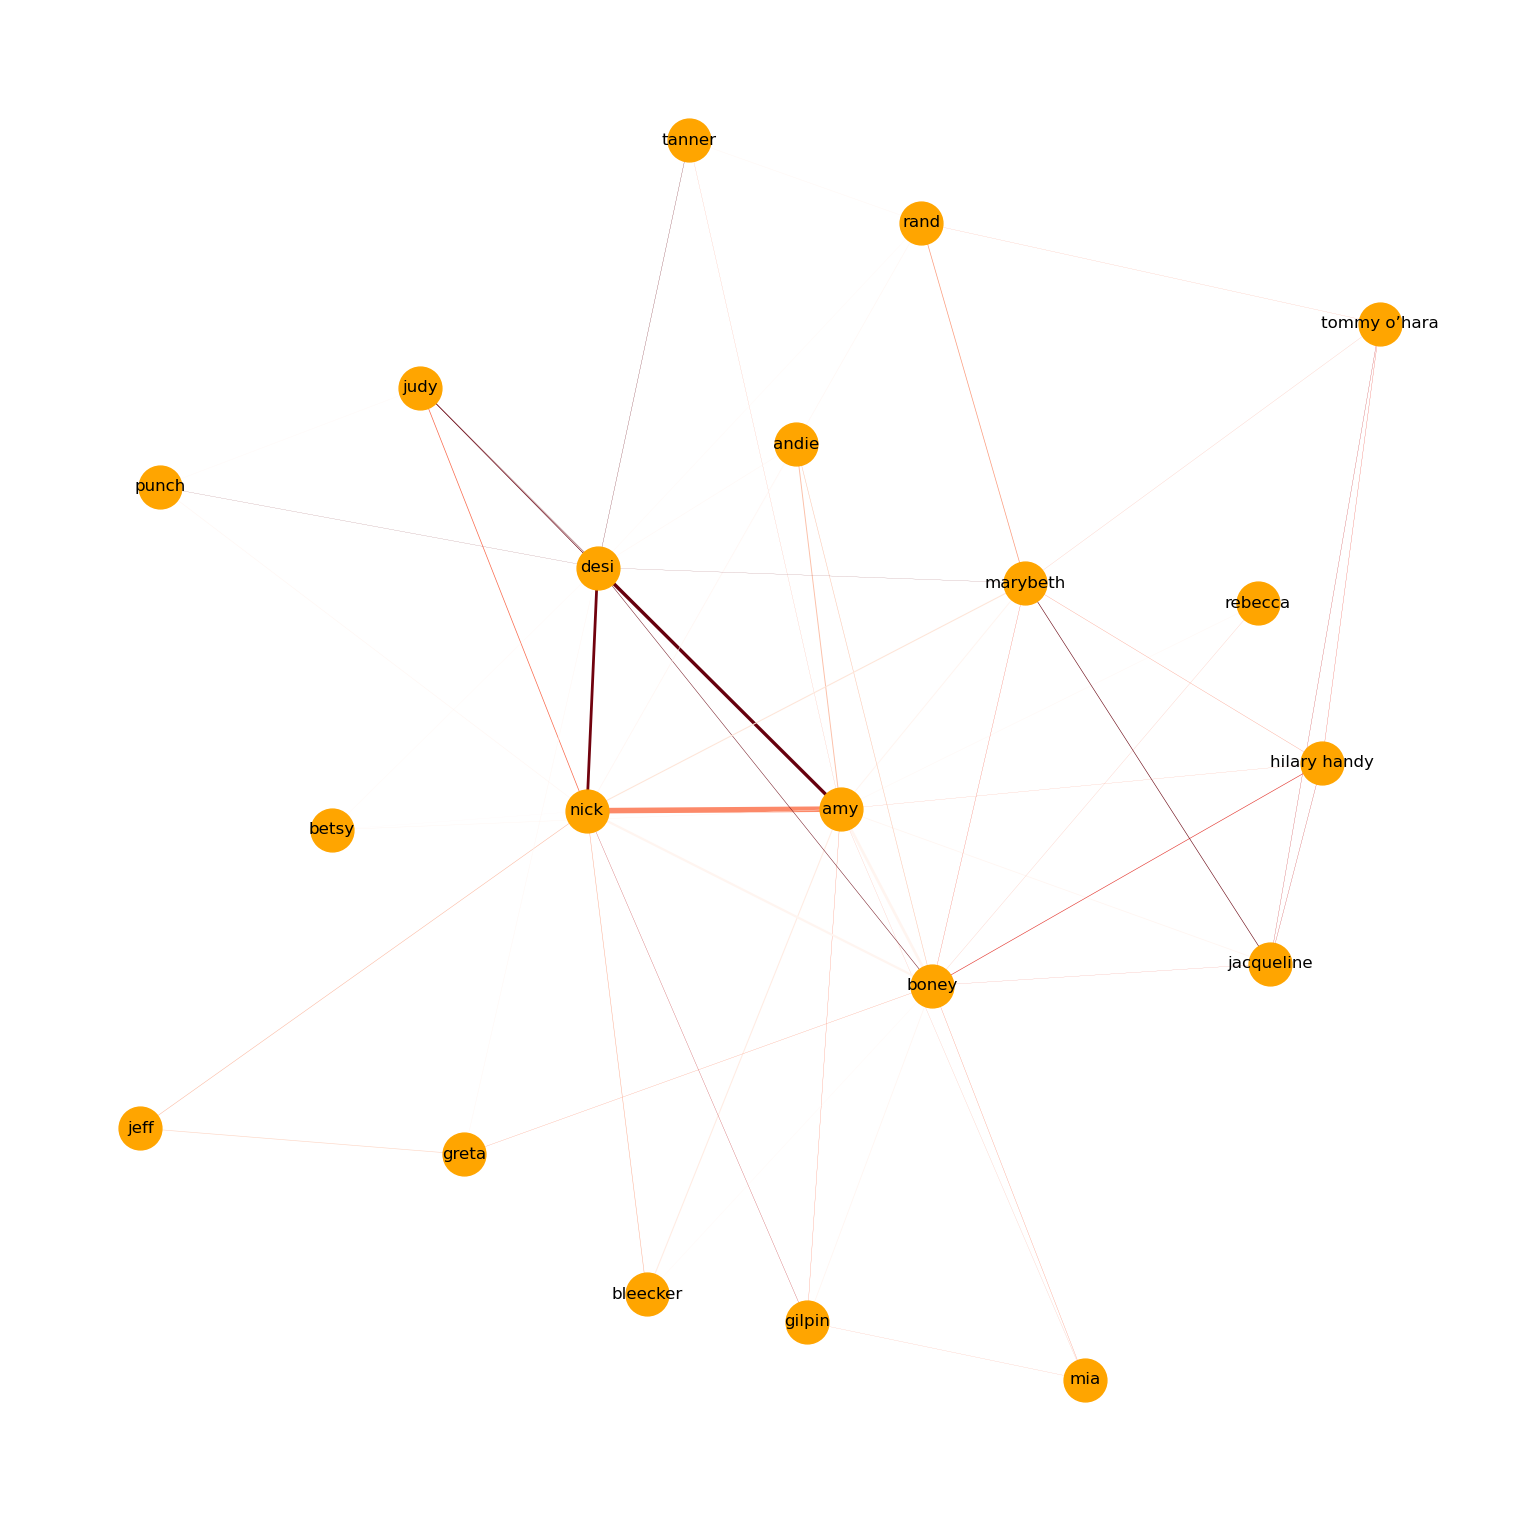

In [45]:
# change the coocurence ratio to better fit network aesthetics/readability
gg3_relationship_df['num_cooccurence'] = gg3_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg3_relationship_df
G = nx.from_pandas_edgelist(gg3_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

Judy becomes more relevant in the narrative, but the model ceases to understand the Punch and Judy characters as metaphors and not actual people in the story. Desi becomes an antagonistic figure as both main characters establish and end the narrative with a negative relationship with him. Boney becomes a smaller character in the final section of the novel, and the main dynamic returns to Nick and Amy once again as shown by the edge width.  

Although Amy and Nick's dynamic becomes lighter in color, suggesting a mending in the last section of the novel, the network does not recognize the unnatural aspects of their relationship in which they perform a positive dynamic for an outside audience. 



## Novel Analysis <a class="anchor" id="Novel_Analysis"></a>

With the generated networks for each of the three parts of *Gone Girl*, we can now attempt to analyze the novel as a whole. To do so, it would be interesting to start by visualizing an overarching network for the entire text.

In [46]:
gg_char_entity_df = []

# concatenate all char_entity_df into one giant one
frames = [gg1_char_entity_df, gg2_char_entity_df, gg3_char_entity_df]
gg_char_entity_df = pd.concat(frames)

# remove sentences without character entities
gg_char_entity_df = gg_char_entity_df[gg_char_entity_df['char_entities'].map(len) > 0]

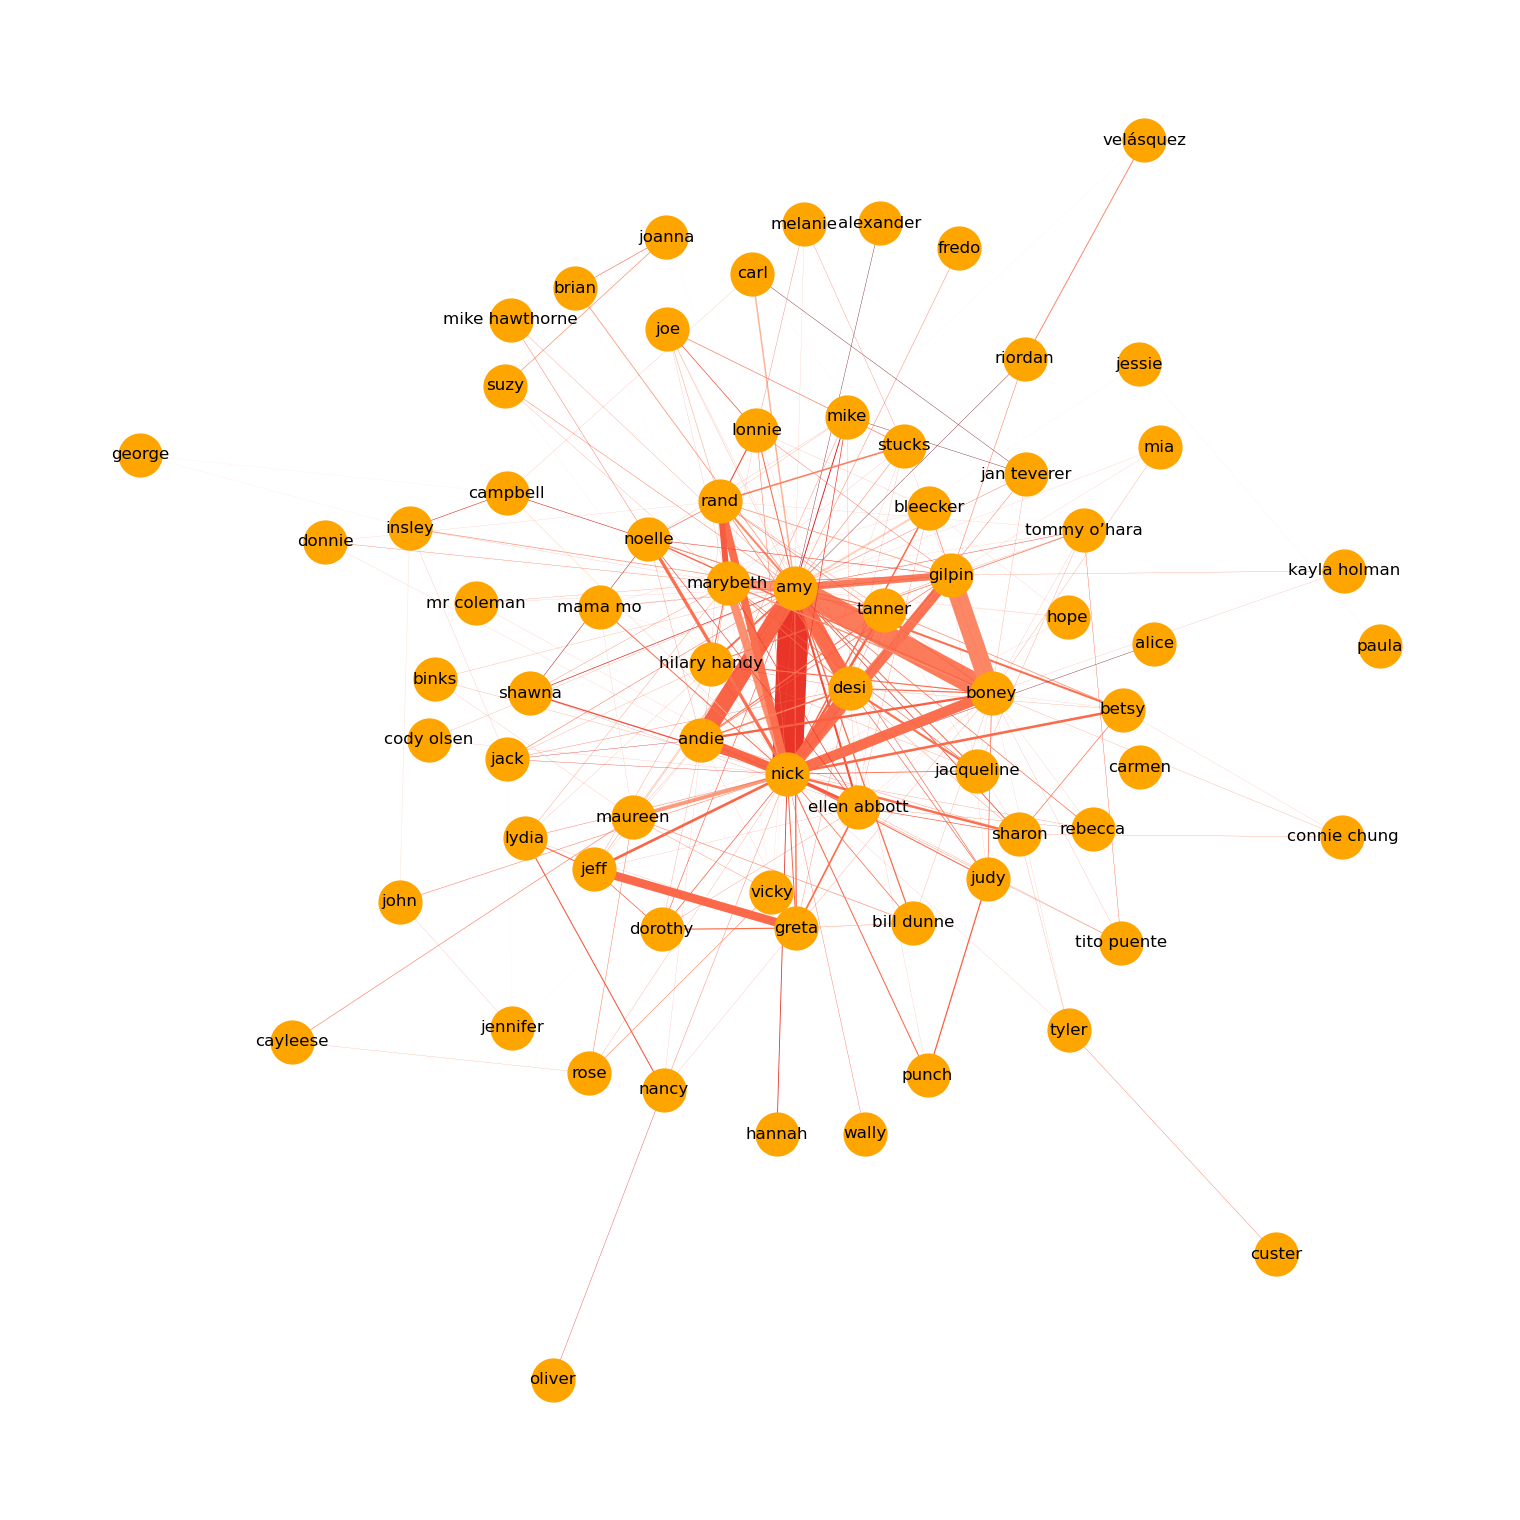

In [47]:
# create a relationship dataframe and print preview of results
gg_relationship_df = pd.DataFrame(create_char_relationships(gg_char_entity_df.reset_index()))

# assign values based on number of relationships
gg_relationship_df["num_cooccurence"] = 1
gg_relationship_df = gg_relationship_df.groupby(["source","target"], sort=False, as_index=False).agg({'sentiment_score':'mean', 'num_cooccurence':'sum'})

# remove character relationships with themselves
gg_relationship_df = gg_relationship_df.loc[gg_relationship_df['source'] != gg_relationship_df['target']] 

# change the coocurence ratio to better fit network aesthetics/readability
gg_relationship_df['num_cooccurence'] = gg_relationship_df['num_cooccurence'].apply(lambda x: x/12)

# create the character network based off of gg_relationship_df
G = nx.from_pandas_edgelist(gg_relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = ["num_cooccurence", "sentiment_score"], 
                            create_using = nx.Graph())

plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G)

edges = G.edges()
# edge colors correspond to sentiment score
colors = [G[u][v]['sentiment_score'] for u, v in edges]
# edge weights correspond to number of co-occurences
weights = [G[u][v]['num_cooccurence'] for u, v in edges]

nx.draw(G, with_labels=True, node_color='orange', node_size=950,
        edge_cmap=plt.cm.Reds_r, pos=pos, edge_color=colors, edge_vmin=-0.018, edge_vmax=0.018,
        width=weights)

Based on the entire novel's character network, Amy and Nick remain the focal points of the plot and maintain strong relationships with characters the other has. For example, both characters have many interactions with Andie, Desi, and Tanner. As the edge color is the darkest between Amy and Nick as well, the network suggests an antagonistic relationship between the two characters. 

While the network is able to depict the relationship and interactions between characters with great accuracy, the nature of Boney's dynamic with Amy is still an inconsistency. A close reading of the text reveals Boney to have a parasocial relationship with Amy which is one-sided while they interact minimally in actuality; therefore, the network only shows Boney's understanding of Amy and not Amy's perspective on Boney. The network continues to highlight Boney's connection to Gilpin, as they are partners. 

To make sense of what the graph is showing us, we can compute the character centrality for the network and determine which character has the most interactions.

In [48]:
# convert character centrality into dataframe and sort based on centrality value
gg_char_centrality = pd.DataFrame(nx.degree_centrality(G).items(), columns=['character', 'centrality_value'])
gg_char_centrality = gg_char_centrality.sort_values(['centrality_value'], ascending=[False])

# take a look at the data
gg_char_centrality.head(10)

,character,centrality_value
0,amy,0.742857
1,nick,0.671429
10,boney,0.428571
6,marybeth,0.357143
29,desi,0.314286
43,andie,0.257143
13,rand,0.242857
46,ellen abbott,0.228571
9,gilpin,0.228571
28,hilary handy,0.185714


BookNLP offers interesting processing tools that might reveal character and plot elements. Therefore, we will take the top ten characters - Amy, Nick, Boney, Marybeth, Desi, Andie, Rand, Ellen Abbott, Gilpin, and Hilary Handy - and see what natural language processing tools can reveal another layer to the relationships between co-occurence and sentiment analysis.

In [49]:
# get the book data from BookNLP output
gone_girl_data = proc(r"C:\Users\tracypaige\LTCS180\bookNLP_gillian_flynn\gone_girl\gone_girl.book")
character_data = create_character_data(gone_girl_data, 20)

# create a dataframe for the data
df_bookNLP = pd.DataFrame(character_data).T.reset_index(drop=True)

# filter specified characters
top_central_char = ["Amy", "Nick", "Boney", "Marybeth", "Desi", "Andie", "Rand", "Ellen Abbott", "Gilpin", "Hilary Handy"]
df_bookNLP = df_bookNLP[df_bookNLP['name'].isin(top_central_char)].drop_duplicates(subset=['name'])

In [50]:
# print out each character's modList
print('\033[1m' + "These are the lists of words BookNLP detects to describe each character:" + '\033[0m')
for (idx, row) in df_bookNLP.iterrows():
    modList = []
    for tuple in row.modList:
        modList.append(tuple[1].lower())
    print(colored(str(row['name']) + ": ", "red") , ', '.join(modList))

These are the lists of words BookNLP detects to describe each character:
Amy:  pregnant, afraid, woman, alive, perfect, happy, scared, person, wealthy, brilliant, right, dead, interested, proud, fine, oblivious, botcher, clever, ones, bread
Nick:  man, guy, angry, sure, worried, okay, calm, friendly, pretty, serious, husband, interested, son, good, furious, drunk, kind, eyed, jackass, happier
Desi:  guy, able, figure, kid, rude, fop, about, suspect, type, happier, grateful, gentle, annoying, one, pariah, footnote, collector, genuine, silent, wrong
Boney:  convinced, open, frightened, afraid, thrilled, innocent, right, man
Andie:  girl, young, old, kind, ashamed, worried, hugger, prone, warm, unassuming, easy, patient, dangerous, excited, willing, antidote, liability, married, shit, able
Rand:  about, host, right, busy, provincial, tight, liaison, next, taller
Gilpin:  thrilled
Marybeth:  
Ellen Abbott:  woman, part, vicious, voice
Hilary Handy:  resentful


In [51]:
# print out each character's possList
print('\033[1m' + "These are the lists of nouns BookNLP detects that each character possesses:" + '\033[0m')
for (idx, row) in df_bookNLP.iterrows():
    possList = []
    for tuple in row.possList:
        possList.append(tuple[1].lower())
    print(colored(str(row['name']) + ": ", "red") , ', '.join(possList))

These are the lists of nouns BookNLP detects that each character possesses:
Amy:  parents, husband, hair, face, name, head, friend, clock, wife, friends, eyes, photo, disappearance, brain, mind, purse, lies, story, family, clue
Nick:  wife, mom, dad, face, hands, father, job, life, eyes, cell, mouth, shortcomings, office, birthday, anniversary, arms, voice, friends, computer, mother
Desi:  mother, house, eyes, arm, blood, girlfriend, shoulder, jaguar, lips, neck, hands, cock, home, family, roadster, neighborhood, doorbell, room, shoelaces, condolences
Boney:  head, hair, eyes, hands, wife, mouth, voice, job, breath, fingerprints, throat, notes, phone, coffee, car, gaze, nest, choosing, nose, cell
Andie:  breasts, face, hair, cheeks, eyes, lip, mouth, story, neck, building, friends, mom, wife, coffee, set, mother, fingers, sundress, lips, sister
Rand:  wife, head, eyes, daughter, mouth, smile, bed, glasses, stare, arm, thing, voice, cheeks, office, hair, routine, face, show, shirt, shou

If we recall the relationship dataframe for the entire novel, we can contextualize what we see in the network, as well as what BookNLP provides.

In [52]:
# sort relationship dataframe by num_cooccurence
gg_relationship_df = gg_relationship_df.sort_values(['num_cooccurence'], ascending=[False])
gg_relationship_df.head(10)

,source,target,sentiment_score,num_cooccurence
0,amy,nick,-0.005374,21.916667
17,amy,boney,0.001936,16.333333
18,boney,gilpin,0.003357,13.166667
155,amy,andie,-0.000613,12.500000
76,amy,desi,0.000323,10.833333
172,desi,nick,0.000099,8.083333
24,boney,nick,0.000546,7.500000
21,gilpin,nick,0.001072,7.250000
154,andie,nick,-0.000344,6.916667
10,amy,marybeth,0.005221,6.666667


For example, here, we see that Nick and Amy have the most interactions. In the character network, this interaction is represented by the widest line and characterized by the darkest red. From this, we can tell that their relationship is at the core of the novel's plot. Furthermore, from the BookNLP data, we can gather that they are likely husband and wife. A couple of Amy's primary descriptors include "pregnant" and "afraid" while a couple of Nick's primary descriptors include "angry" and "sure." Some prominent nouns related to Amy include "disappearence," "brain," and "lies" while some prominent nouns related to Nick include "shortcomings," "birthday," and "anniversary." From the sentiment value, we can tell that their relationship was mostly negative.

Thus, solely from these computed aspects, somebody who hasn't read *Gone Girl* would be able to guess that a significant portion of the plot revolves around the disappearence of Amy, who is possibly pregnant. Her husband, Nick, is likely an angry person, and their relationship could be characterized by a birthday or anniversary.

## Project Conclusion <a class="anchor" id="Project_Conclusion"></a>

With the combined components of name entity recognition for detecting character entities, sentiment analysis for detecting the nature of character relationships, and natural language processing for text analysis, the computational aspect of distant reading provides a pretty close representation of *Gone Girl*'s plot and characters. We were able to produce interesting analyses and draw connections between the data and the text.

Our project utilizes co-occurence to determine the number of character interactions. We searched for these co-occurences through windows of three sentences; this granularity had a large impact over the arrangement of the character networks. Had we chosen a different window size, it is possible the networks could look different from what they look like now. Furthermore, we drew from a list of characters generated by BookNLP (through NER) so that we could align the data we found in the character networks to the character/plot information from BookNLP; by manually filtering out inaccuracies, we recognize that there could be some characters that NER didn't detect. However, since we did not notice them, any characters missed would likely have only been minor characters, so wouldn't have impacted the networks significantly. We also recognize that there are many more libraries that exist that produce similar techniques for text processing. Perhaps using different libraries could have produced different results.

Despite the model's ability to plot the emotional variations in the novel, there were some discrepancies that were lost. An integral aspect of Gillian Flynn’s storytelling in *Gone Girl* is the characterization of both perspectives, Amy Dunne and Nick Dunne, as unreliable narrators. While properties of the network, such as the edge width as an indicator of interactions between characters, are tedious to monitor through close reading, the intricacies of the character relationships are lost through the edge color. The characters have distinct and opposing perspectives on episodes that occured between them, and one of the characters even admits to fabricating stories in her journal— which is included in the novel. Some characters maintain one-sided relationships, like Boney's understanding of Amy; however, this detail becomes lost in the character model which suggests a two-sided dynamic. Although a model which displays the disparities in *Gone Girl*'s plot could be a future project due to the novel's entanglements, in sentiment analysis, these details become lost. However, the narrators' conflicting views add to the negative sentiment which is highlighted through the darker red color on the character network. 

The most precise and realistic method to analyze the complexities of *Gone Girl* would be to use a combination of close and distant reading. Even when constructing a model for the novel’s characters, spaCy’s Name Entity Recognition model needed to be cleaned up by someone familiar with the contents; the model had logged entities such as “stress” and “clue one” as characters. Without a close reading, vital characters such as Margot, would have been overlooked as well. These findings are also a representation of Flynn's writing style which varies depending on the relationship between characters, such as the use of nicknames, and a character's intention in telling a particular narrative. 

For this project, we produced computational and written analysis for only one book. It would be interesting for us to expand on this in the future if we wanted to compare whether or not we deem distant reading to be equally accurate across the author's full body of work. Additionally, it would be interesting to see if accuracy changes for different genres, as *Gone Girl* is a thriller/mystery novel.